### Make timeseries of SIA, NPP, KGP, fish, and penguins for 7 regions

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath
import cmocean

import cartopy.feature as cfeature
import matplotlib.ticker as mticker

### Get grid info

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

area_km2 = area * 1e-10

In [3]:
years = np.arange(1920,2101,1)

In [4]:
years = xr.DataArray(years,dims=('time'))

### Make a SIZ mask, so then we can do an area-weighted average for each longitude

In [6]:
## based on CESM1-LE -- will redo!!
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

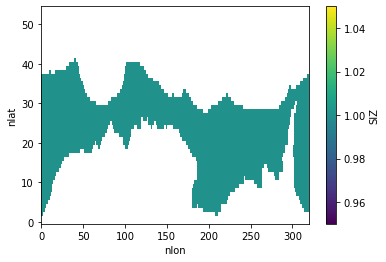

In [7]:
ds_siz_mask.SIZ.plot()

In [9]:
siz_mask = ds_siz_mask.SIZ

### Add maps below for one interesting season for each variable

    • ICE - SON
    • NPP - ONDJFM
    • zooC = JFM
    • KGP = JFM
    • fish total = annual
    • fish ice = annual
    • Emperor = annual
    • Adelie = annual

In [10]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(file)
ds_npp = ds_npp.isel(time=slice(70,250),nlat=slice(0,55))
ds_npp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    NPP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    NPP_OND     (time, member_id, nlat, nlon) float64 ...
    NPP_JFM     (time, member_id, nlat, nlon) float64 ...
    NPP_AMJ     (time, member_id, nlat, nlon) float64 ...
    NPP_JAS     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly NPP in the Southern Ocean from 1850 to 2099. Each...

In [11]:
ds_npp.NPP_ONDJFM.attrs

{'units': 'mmol/m2/season'}

In [12]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-means-IFRAC-hi_v4.nc'
ds_ice = xr.open_dataset(file)
ds_ice = ds_ice.isel(time=slice(70,250))
ds_ice

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time          (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 ...
    SIT_OND       (time, member_id, nlat, nlon) float64 ...
    SIT_JFM       (time, member_id, nlat, nlon) float64 ...
    SIT_AMJ       (time, member_id, nlat, nlon) float64 ...
    SIT_JAS       (time, member_id, nlat, nlon) float64 ...
    SIT_ONDJFM    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

In [13]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(file)
ds_kgp = ds_kgp.isel(nlat=slice(0,55))
ds_kgp = ds_kgp.isel(time=slice(70,250))
ds_kgp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    KGP_OND     (time, member_id, nlat, nlon) float64 ...
    KGP_JFM     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2024-01-23
    contents:        yearly KGP in the Southern Ocean from 1850 to 2099. Each...

In [14]:
ds_kgp['KGP_OND'] = ds_kgp['KGP_OND'].where(ds_kgp['KGP_OND']>0,other=0)
ds_kgp['KGP_JFM'] = ds_kgp['KGP_JFM'].where(ds_kgp['KGP_JFM']>0,other=0)

In [16]:
basep_kgp_ond = ds_kgp.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id'))
basep_kgp_jfm = ds_kgp.KGP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id'))
ds_kgp['KGP_OND'] = ds_kgp.KGP_OND.where(basep_kgp_ond > 0.001)
ds_kgp['KGP_JFM'] = ds_kgp.KGP_JFM.where(basep_kgp_jfm > 0.001)

#### mask out placse in the KGP dataset that are:
### 1) outside of the SIZ
### 2) less than one (these = 0)
### 3) KGP during base period too low to reliably estimate standard deviation and therefore ToE

In [17]:
ds_fish = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/FEISTY_ann_tot_fish.nc')

In [18]:
ds_fish = ds_fish.isel(time=slice(70,250))

In [19]:
ds_fish_start = ds_fish.isel(time=slice(0,30)).mean(dim=('time','member_id')).load()
ds_fish_end = ds_fish.isel(time=slice(150,180)).mean(dim=('time','member_id')).load()

thres_totfish = ds_fish_end.total_fish.where(ds_fish_start.total_fish>0.05)
thres_icefish = ds_fish_end.total_fish_ice.where(ds_fish_start.total_fish_ice>0.05)

ds_fish['total_fish'] = ds_fish['total_fish'].where(thres_totfish > 0)
ds_fish['total_fish_ice'] = ds_fish['total_fish_ice'].where(thres_icefish > 0)

### Put all these together into one dataset

In [20]:
ds = xr.Dataset()
ds['NPP_ONDJFM'] = ds_npp.NPP_ONDJFM
ds['NPP_OND'] = ds_npp.NPP_OND
ds['NPP_JFM'] = ds_npp.NPP_JFM
ds['IFRAC_SON'] = ds_ice.IFRAC_SON
ds['IFRAC_MAM'] = ds_ice.IFRAC_MAM
ds['IFRAC_OND'] = ds_ice.IFRAC_OND
ds['IFRAC_JFM'] = ds_ice.IFRAC_JFM
ds['SIT_JFM'] = ds_ice.SIT_JFM
ds['SIT_OND'] = ds_ice.SIT_OND
ds['SIT_ONDJFM'] = ds_ice.SIT_ONDJFM
ds['IFRAC_ONDJFM'] = ds_ice.IFRAC_ONDJFM
ds['KGP_JFM'] = ds_kgp.KGP_JFM
ds['KGP_OND'] = ds_kgp.KGP_OND
ds['KGP_ONDJFM'] = ds_kgp.KGP_ONDJFM
ds['total_fish'] = ds_fish.total_fish
ds['total_fish_ice'] = ds_fish.total_fish_ice

#### get emperor penguin timeseries data

In [21]:
import pandas as pd

In [22]:
years = np.arange(1920,2101,1)
regs = ['AP','EAnt','Wedd','Adelie','Ross','AmBel','Prydz']
sims = np.arange(0,50,1)

In [27]:
emp_dict = {}
i=1
for reg in regs:
    file = '/glade/work/kristenk/penguin_data/Emperor_data_regions2/R_regionKK3_'+str(i)+'.csv'
    df_emp = pd.read_csv(file,header=None)
    ##### calculate mean!
    df_emp['mean']= df_emp[sims].mean(axis=1)
    df_emp['year'] = years
    emp_dict[reg] = xr.DataArray(df_emp[sims],dims=('time','sim'))
    emp_dict[reg]['time'] = years
    i = i + 1

In [28]:
emp_dict['AP']

<xarray.DataArray (time: 181, sim: 50)>
array([[0.98176128, 1.01843744, 1.02915111, ..., 1.02894456, 1.02460006,
        1.00797873],
       [1.02632014, 0.99350497, 0.99736896, ..., 1.01760276, 1.01375795,
        1.02284686],
       [1.01625035, 1.02399122, 1.0213943 , ..., 1.02807143, 1.02325795,
        1.00819105],
       ...,
       [0.82378766, 0.84590471, 0.88591335, ..., 0.82444331, 0.80029285,
        0.86525571],
       [0.82871029, 0.7590293 , 0.83179684, ..., 0.83974723, 0.72558199,
        0.84486447],
       [0.76081971, 0.7380884 , 0.84651985, ..., 0.84337518, 0.73520821,
        0.85229433]])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
  * sim      (sim) object 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49

In [29]:
#### add Emperor global pop
reg = 'SIZ'
file = '/glade/work/kristenk/penguin_data/Emperor_data_regions2/R_globalKK3_7.csv'
df_emp = pd.read_csv(file,header=None)
##### calculate mean!
#df_emp['mean']= df_emp[sims].mean(axis=1)
#df_emp['year'] = years
emp_dict[reg] = xr.DataArray(df_emp,dims=('time','sim'))
emp_dict[reg]['time'] = years

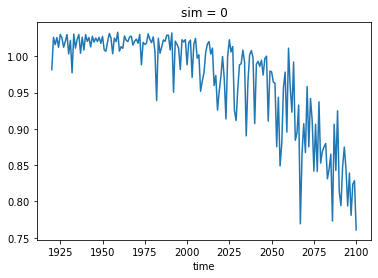

In [30]:
emp_dict['AP'].isel(sim=0).plot()

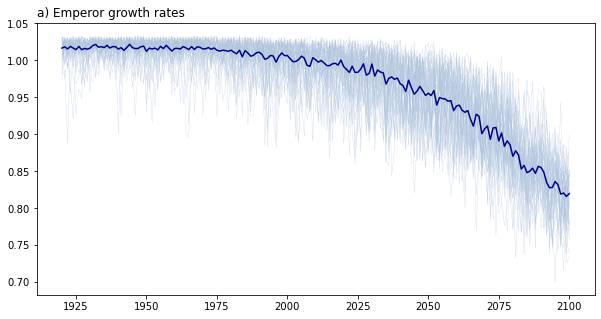

In [31]:
fig = plt.figure(figsize=(10,5))

#cmap = 'ice_cats'
#################
ax = fig.add_subplot(1, 1, 1)
ax.set_title("a) Emperor growth rates", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(emp_dict['AP'].time, emp_dict['AP'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
    
ax.plot(emp_dict['AP'].time, emp_dict['AP'].mean(dim='sim'),
           color='darkblue', zorder=2)


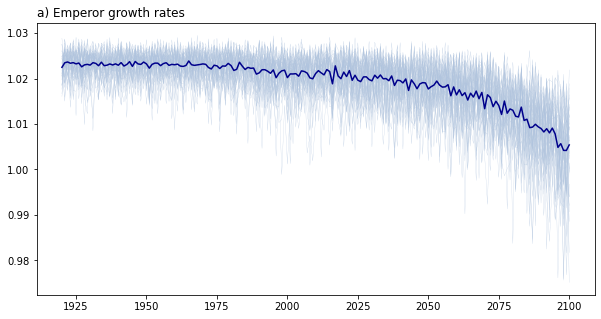

In [32]:
fig = plt.figure(figsize=(10,5))

#cmap = 'ice_cats'
#################
ax = fig.add_subplot(1, 1, 1)
ax.set_title("a) Emperor growth rates", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(emp_dict['Ross'].time, emp_dict['Ross'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
    
ax.plot(emp_dict['Ross'].time, emp_dict['Ross'].mean(dim='sim'),
           color='darkblue', zorder=2)

In [33]:
emp_dict['Ross']

<xarray.DataArray (time: 181, sim: 50)>
array([[1.01664864, 1.021106  , 1.02025095, ..., 1.02437811, 1.02501534,
        1.02490874],
       [1.02588944, 1.02473828, 1.02292264, ..., 1.02293673, 1.02513833,
        1.02366926],
       [1.02059047, 1.02658026, 1.02333956, ..., 1.02228576, 1.02479019,
        1.02292373],
       ...,
       [1.00328748, 1.00144699, 1.00188905, ..., 1.00504957, 1.00288847,
        0.99007698],
       [1.00496598, 1.01077625, 1.01734932, ..., 1.00160973, 1.00133598,
        1.00035336],
       [0.99934481, 1.00235966, 0.99068238, ..., 1.01645297, 1.00954455,
        1.01357161]])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
  * sim      (sim) object 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49

#### get Adelie penguin data

In [36]:
adelie_dict = {}
adel_regs = ['AP','Adelie','Ross','AmBel','Prydz','SIZ']
adel_years = np.arange(1920,2101,1)
sims = np.arange(1,51,1)
i=0
for reg in ['1','4','5','6','7']:
    file = '/glade/work/kristenk/penguin_data/Adelie_data2/r_region'+reg+'_adpe.csv'
    df_adel_reg = pd.read_csv(file,header=None)
    df_adel_reg = df_adel_reg.T #transpose data file
    # df_adel_reg['mean']= df_adel_reg[sims].mean(axis=1)
    ## transform out of log space
    df_adel_reg[sims] = 10**(df_adel_reg[sims])
    adelie_dict[adel_regs[i]] = xr.DataArray(df_adel_reg[sims],dims=('time','sim')).isel(time=slice(20,202))
    adelie_dict[adel_regs[i]]['time'] = adel_years
    
    i = i + 1

In [37]:
### get the circumpolar data

file = '/glade/work/kristenk/penguin_data/Adelie_data2/r_cpolar_adpe.csv'
df_adel_reg = pd.read_csv(file,header=None)
df_adel_reg = df_adel_reg.T #transpose data file
# df_adel_reg['mean']= df_adel_reg[sims].mean(axis=1)
## transform out of log space
df_adel_reg[sims] = 10**(df_adel_reg[sims])
adelie_dict[adel_regs[5]] = xr.DataArray(df_adel_reg[sims],dims=('time','sim')).isel(time=slice(20,202))
adelie_dict[adel_regs[5]]['time'] = adel_years

In [38]:
adelie_dict['SIZ']

<xarray.DataArray (time: 181, sim: 50)>
array([[0.91792503, 0.92228944, 0.95206375, ..., 0.94048872, 0.95693322,
        0.93635773],
       [0.94770448, 0.93615187, 0.92775678, ..., 0.97385871, 0.92816364,
        0.95531905],
       [0.98107444, 0.93321076, 0.93097284, ..., 0.95708471, 0.95810231,
        0.93308257],
       ...,
       [1.05959345, 1.07297424, 1.0661075 , ..., 1.07088887, 1.0633788 ,
        1.05536974],
       [1.07081725, 1.06162969, 1.06632788, ..., 1.05678935, 1.0618647 ,
        1.05757046],
       [1.0659459 , 1.05969503, 1.07194222, ..., 1.0590368 , 1.06413079,
        1.06647644]])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
  * sim      (sim) int64 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50

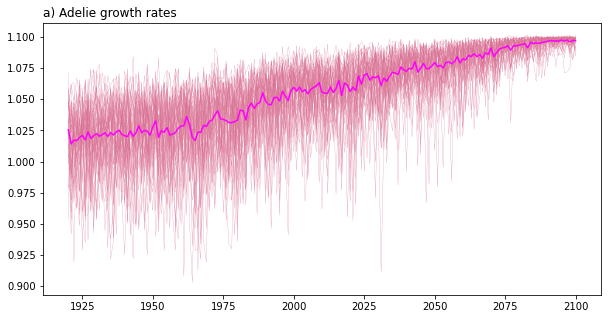

In [39]:
fig = plt.figure(figsize=(10,5))

#cmap = 'ice_cats'
#################
ax = fig.add_subplot(1, 1, 1)
ax.set_title("a) Adelie growth rates", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(adelie_dict['Ross'].time, adelie_dict['Ross'].isel(sim=mem), color='palevioletred',linewidth=0.2)
    
ax.plot(adelie_dict['Ross'].time, adelie_dict['Ross'].mean(dim='sim'),
           color='magenta', zorder=2)

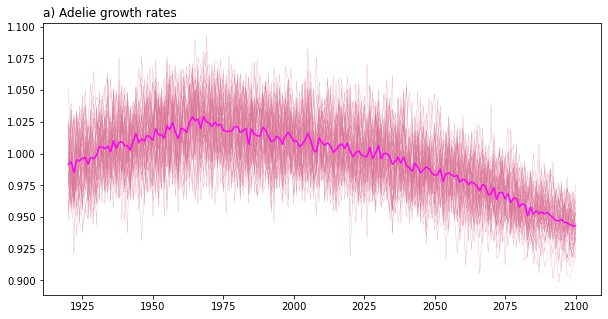

In [40]:
fig = plt.figure(figsize=(10,5))

#cmap = 'ice_cats'
#################
ax = fig.add_subplot(1, 1, 1)
ax.set_title("a) Adelie growth rates", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(adelie_dict['AP'].time, adelie_dict['AP'].isel(sim=mem), color='palevioletred',linewidth=0.2)
    
ax.plot(adelie_dict['AP'].time, adelie_dict['AP'].mean(dim='sim'),
           color='magenta', zorder=2)

### Make regional averages

In [41]:
ones = np.full((55,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)


### Antarctic peninsula tip
box1_latmin = -67
box1_latmax = -62
box1_lonmin = -64.
box1_lonmax = -53.

### East Antarctic
box2_latmin = -70
box2_latmax = -65
box2_lonmin = 12.
box2_lonmax = 30.

### Weddell sea 
box3_latmin = -80 #-79
box3_latmax = -72
box3_lonmin = -55 #-50.
box3_lonmax = -32.

### Terre Adelie
box4_latmin = -67
box4_latmax = -65
box4_lonmin = 136.
box4_lonmax = 142.

### Ross Sea
box5_latmin = -78
box5_latmax = -70
box5_lonmin = 165. ## these are in degrees East (crosses dateline)!!...so 170E to 160W
box5_lonmax = 200.

### Amundsen-Bellingshausen
box6_latmin = -75
box6_latmax = -68
box6_lonmin = -120.
box6_lonmax = -80.

### Prydz bay
box7_latmin = -70
box7_latmax = -65
box7_lonmin = 65.
box7_lonmax = 85.

In [42]:
mask1 = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
mask2 = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
mask3 = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
mask4 = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
## ross use deg east lons
mask5 = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons<box5_lonmax).where(lons>box5_lonmin)
mask6 = ones.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)
mask7 = ones.where(lats<box7_latmax).where(lats>box7_latmin).where(lons_norm<box7_lonmax).where(lons_norm>box7_lonmin)

In [43]:
ts_AP = xr.Dataset()
ts_EAnt = xr.Dataset()
ts_Wedd = xr.Dataset()
ts_Adelie = xr.Dataset()
ts_SIZ = xr.Dataset()
ts_Prydz = xr.Dataset()
ts_AmBel = xr.Dataset()
ts_Ross = xr.Dataset()

for v in ['KGP_ONDJFM','KGP_OND','KGP_JFM','NPP_ONDJFM','NPP_OND','NPP_JFM','total_fish','total_fish_ice']:
        
        
    ######### first do AP

    masked_area = area.where(mask1==1)
    
    masked_fosi = ds[v].where(mask1==1)
    masked_area['nlat'] = mask1.nlat
    masked_area['nlon'] = mask1.nlon
    
    ts_AP[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    ######### do East Antarctica
    
    masked_area = area.where(mask2==1)
    masked_area['nlat'] = mask2.nlat
    masked_area['nlon'] = mask2.nlon
    
    masked_fosi = ds[v].where(mask2==1)
    
    ts_EAnt[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    
    #########  Weddell
    
    masked_area = area.where(mask3==1)
    masked_area['nlat'] = mask3.nlat
    masked_area['nlon'] = mask3.nlon
    
    masked_fosi = ds[v].where(mask3==1)
    
    ts_Wedd[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #########  Terre Adelie
    
    masked_area = area.where(mask4==1)
    masked_area['nlat'] = mask4.nlat
    masked_area['nlon'] = mask4.nlon
    
    masked_fosi = ds[v].where(mask4==1)
    
    ts_Adelie[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    ######## Whole SIZ
    masked_area = area.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    
    masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
    
    ts_SIZ[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #########  Ross Sea
    
    masked_area = area.where(mask5==1)
    masked_area['nlat'] = mask5.nlat
    masked_area['nlon'] = mask5.nlon
    
    masked_fosi = ds[v].where(mask5==1)
    
    ts_Ross[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #########  Am Bell Seas
    
    masked_area = area.where(mask6==1)
    masked_area['nlat'] = mask6.nlat
    masked_area['nlon'] = mask6.nlon
    
    masked_fosi = ds[v].where(mask6==1)
    
    ts_AmBel[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #########  Prydz
    
    masked_area = area.where(mask7==1)
    masked_area['nlat'] = mask7.nlat
    masked_area['nlon'] = mask7.nlon
    
    masked_fosi = ds[v].where(mask7==1)
    
    ts_Prydz[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

In [44]:
#### now to SIZ integral
######### first do AP

for v in ['IFRAC_OND','IFRAC_JFM','IFRAC_ONDJFM']:

    masked_area = area_km2.where(mask1==1)
    
    masked_fosi = ds[v].where(mask1==1)
    masked_area['nlat'] = mask1.nlat
    masked_area['nlon'] = mask1.nlon
    
    ts_AP[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    ######### do East Antarctica
    
    masked_area = area_km2.where(mask2==1)
    masked_area['nlat'] = mask2.nlat
    masked_area['nlon'] = mask2.nlon
    
    masked_fosi = ds[v].where(mask2==1)
    
    ts_EAnt[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    
    #########  Weddell
    
    masked_area = area_km2.where(mask3==1)
    masked_area['nlat'] = mask3.nlat
    masked_area['nlon'] = mask3.nlon
    
    masked_fosi = ds[v].where(mask3==1)
    
    ts_Wedd[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Terre Adelie
    
    masked_area = area_km2.where(mask4==1)
    masked_area['nlat'] = mask4.nlat
    masked_area['nlon'] = mask4.nlon
    
    masked_fosi = ds[v].where(mask4==1)
    
    ts_Adelie[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    ######## Whole SIZ
    masked_area = area_km2.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    
    masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
    
    ts_SIZ[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Ross
    
    masked_area = area_km2.where(mask5==1)
    masked_area['nlat'] = mask5.nlat
    masked_area['nlon'] = mask5.nlon
    
    masked_fosi = ds[v].where(mask5==1)
    
    ts_Ross[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  AmBel
    
    masked_area = area_km2.where(mask6==1)
    masked_area['nlat'] = mask6.nlat
    masked_area['nlon'] = mask6.nlon
    
    masked_fosi = ds[v].where(mask6==1)
    
    ts_AmBel[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))
    
    #########  Prydz
    
    masked_area = area_km2.where(mask7==1)
    masked_area['nlat'] = mask7.nlat
    masked_area['nlon'] = mask7.nlon
    
    masked_fosi = ds[v].where(mask7==1)
    
    ts_Prydz[v+'_SIA_km2'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

In [45]:
ts_SIZ

<xarray.Dataset>
Dimensions:               (member_id: 50, time: 180)
Coordinates:
  * time                  (time) int64 1920 1921 1922 1923 ... 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    KGP_ONDJFM            (time, member_id) float64 5.922 5.974 ... 6.155 7.86
    KGP_OND               (time, member_id) float64 1.973 1.768 ... 5.926 6.662
    KGP_JFM               (time, member_id) float64 5.645 6.093 ... 2.578 2.933
    NPP_ONDJFM            (time, member_id) float64 2.93e+03 ... 5.083e+03
    NPP_OND               (time, member_id) float64 1.141e+03 ... 2.817e+03
    NPP_JFM               (time, member_id) float64 1.789e+03 ... 2.266e+03
    total_fish            (member_id, time) float64 0.3991 0.405 ... 0.7214
    total_fish_ice        (member_id, time) float64 0.2103 0.2212 ... 0.1817
    IFRAC_OND_SIA_km2     (time, member_id) float64 1.225e+07 ... 5.552e+06
    IFRAC_JFM_SIA_km2     (time, member_id) float64 4.12e+06 ... 2.631e+05
    IFRAC_ONDJFM_SIA_km2  (time, member_id) float64 8.23e+06 ... 2.936e+06

#### calculate ToE and value at ToE for all metrics/seasons

In [46]:
ts_AP['Emperors'] = xr.DataArray(emp_dict['AP'],dims=('time','sim'))

In [47]:
ts_AP['Emperors']

<xarray.DataArray 'Emperors' (time: 180, sim: 50)>
array([[0.98176128, 1.01843744, 1.02915111, ..., 1.02894456, 1.02460006,
        1.00797873],
       [1.02632014, 0.99350497, 0.99736896, ..., 1.01760276, 1.01375795,
        1.02284686],
       [1.01625035, 1.02399122, 1.0213943 , ..., 1.02807143, 1.02325795,
        1.00819105],
       ...,
       [0.78098889, 0.78573128, 0.83288887, ..., 0.79477856, 0.747691  ,
        0.82975917],
       [0.82378766, 0.84590471, 0.88591335, ..., 0.82444331, 0.80029285,
        0.86525571],
       [0.82871029, 0.7590293 , 0.83179684, ..., 0.83974723, 0.72558199,
        0.84486447]])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2095 2096 2097 2098 2099
  * sim      (sim) object 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49

In [48]:
### Find ToE for DECREASING SIA

### SIA
ToE_SIZ = xr.Dataset()
ToE_AP = xr.Dataset()
ToE_Wedd = xr.Dataset()
ToE_EAnt = xr.Dataset()
ToE_Prydz = xr.Dataset()
ToE_Adelie = xr.Dataset()
ToE_Ross = xr.Dataset()
ToE_AmBel = xr.Dataset()

ToEval_SIZ = xr.Dataset()
ToEval_AP = xr.Dataset()
ToEval_Wedd = xr.Dataset()
ToEval_EAnt = xr.Dataset()
ToEval_Prydz = xr.Dataset()
ToEval_Adelie = xr.Dataset()
ToEval_Ross = xr.Dataset()
ToEval_AmBel = xr.Dataset()

basemean_SIZ = xr.Dataset()
basemean_AP = xr.Dataset()
basemean_Wedd = xr.Dataset()
basemean_EAnt = xr.Dataset()
basemean_Prydz = xr.Dataset()
basemean_Adelie = xr.Dataset()
basemean_Ross = xr.Dataset()
basemean_AmBel = xr.Dataset()

basestd_SIZ = xr.Dataset()
basestd_AP = xr.Dataset()
basestd_Wedd = xr.Dataset()
basestd_EAnt = xr.Dataset()
basestd_Prydz = xr.Dataset()
basestd_Adelie = xr.Dataset()
basestd_Ross = xr.Dataset()
basestd_AmBel = xr.Dataset()

### first do sea ice area in OND, JFM, and ONDJFM

for var in ['IFRAC_OND_SIA_km2','IFRAC_JFM_SIA_km2','IFRAC_ONDJFM_SIA_km2']:

    #SIZ
    mean = ts_SIZ[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_SIZ[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_SIZ[var] = ts_SIZ[var]['time'].where(ts_SIZ[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_SIZ[var] = mean-2*std
    basemean_SIZ[var] = mean
    basestd_SIZ[var] = std
    
    #AP
    mean = ts_AP[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_AP[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_AP[var] = ts_AP[var]['time'].where(ts_AP[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_AP[var] = mean-2*std
    basemean_AP[var] = mean
    basestd_AP[var] = std
    
    #Wedd
    mean = ts_Wedd[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Wedd[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_Wedd[var] = ts_Wedd[var]['time'].where(ts_Wedd[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_Wedd[var] = mean-2*std
    basemean_Wedd[var] = mean
    basestd_Wedd[var] = std
    
    #EAnt
    mean = ts_EAnt[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_EAnt[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_EAnt[var] = ts_EAnt[var]['time'].where(ts_EAnt[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_EAnt[var] = mean-2*std
    basemean_EAnt[var] = mean
    basestd_EAnt[var] = std
    
    #Adelie
    mean = ts_Adelie[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Adelie[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_Adelie[var] = ts_Adelie[var]['time'].where(ts_Adelie[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_Adelie[var] = mean-2*std
    basemean_Adelie[var] = mean
    basestd_Adelie[var] = std
    
    #Ross
    mean = ts_Ross[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Ross[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_Ross[var] = ts_Ross[var]['time'].where(ts_Ross[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_Ross[var] = mean-2*std
    basemean_Ross[var] = mean
    basestd_Ross[var] = std
    
    #AmBel
    mean = ts_AmBel[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_AmBel[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_AmBel[var] = ts_AmBel[var]['time'].where(ts_AmBel[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_AmBel[var] = mean-2*std
    basemean_AmBel[var] = mean
    basestd_AmBel[var] = std
    
    #Prydz
    mean = ts_Prydz[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Prydz[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    ToE_Prydz[var] = ts_Prydz[var]['time'].where(ts_Prydz[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToEval_Prydz[var] = mean-2*std
    basemean_Prydz[var] = mean
    basestd_Prydz[var] = std

### Now find ToE, ToE value, and base mean for penguin growth rates

In [49]:
emp_dict.keys()

dict_keys(['AP', 'EAnt', 'Wedd', 'Adelie', 'Ross', 'AmBel', 'Prydz', 'SIZ'])

In [50]:
################## SIZ
## Emperors
mean = emp_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['SIZ'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['SIZ']['time'].where(emp_dict['SIZ'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['SIZ']['time'].where(emp_dict['SIZ'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_SIZ['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_SIZ['Emperor']):
    ToEval_SIZ['Emperor'] = emp_dict['SIZ'].sel(time=int(ToE_SIZ['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_SIZ['Emperor'] = np.nan
basemean_SIZ['Emperor'] = mean
basestd_SIZ['Emperor'] = std

## Adelies 
mean = adelie_dict['SIZ'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['SIZ'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['SIZ']['time'].where(adelie_dict['SIZ'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['SIZ']['time'].where(adelie_dict['SIZ'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_SIZ['Adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_SIZ['Adelie']):
    ToEval_SIZ['Adelie'] = adelie_dict['SIZ'].sel(time=int(ToE_SIZ['Adelie'].values)).mean(dim='sim').values
else:
    ToEval_SIZ['Adelie'] = np.nan
basemean_SIZ['Adelie'] = mean
basestd_SIZ['Adelie'] = std


################## AP
## Emperors
mean = emp_dict['AP'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['AP'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['AP']['time'].where(emp_dict['AP'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['AP']['time'].where(emp_dict['AP'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_AP['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_AP['Emperor']):
    ToEval_AP['Emperor'] = emp_dict['AP'].sel(time=int(ToE_AP['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_AP['Emperor'] = np.nan
basemean_AP['Emperor'] = mean
basestd_AP['Emperor'] = std
## Adelies (starts at 1939, so only 12 years of base period)
mean = adelie_dict['AP'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['AP'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['AP']['time'].where(adelie_dict['AP'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['AP']['time'].where(adelie_dict['AP'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_AP['Adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_AP['Adelie']):
    ToEval_AP['Adelie'] = adelie_dict['AP'].sel(time=int(ToE_AP['Adelie'].values)).mean(dim='sim').values
else:
    ToEval_AP['Adelie'] = np.nan
basemean_AP['Adelie'] = mean
basestd_AP['Adelie'] = std

######################## EAnt
## Emperors
mean = emp_dict['EAnt'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['EAnt'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['EAnt']['time'].where(emp_dict['EAnt'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['EAnt']['time'].where(emp_dict['EAnt'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_EAnt['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_EAnt['Emperor']):
    ToEval_EAnt['Emperor'] = emp_dict['EAnt'].sel(time=int(ToE_EAnt['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_EAnt['Emperor'] = np.nan
basemean_EAnt['Emperor'] = mean
basestd_EAnt['Emperor'] = std

##################### Wedd
## Emperors
mean = emp_dict['Wedd'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['Wedd'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['Wedd']['time'].where(emp_dict['Wedd'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['Wedd']['time'].where(emp_dict['Wedd'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Wedd['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Wedd['Emperor']):
    ToEval_Wedd['Emperor'] = emp_dict['Wedd'].sel(time=int(ToE_Wedd['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_Wedd['Emperor'] = np.nan
basemean_Wedd['Emperor'] = mean
basestd_Wedd['Emperor'] = std

################## Terre Adelie 
## Emperors
mean = emp_dict['Adelie'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['Adelie'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['Adelie']['time'].where(emp_dict['Adelie'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['Adelie']['time'].where(emp_dict['Adelie'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Adelie['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Adelie['Emperor']):
    ToEval_Adelie['Emperor'] = emp_dict['Adelie'].sel(time=int(ToE_Adelie['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_Adelie['Emperor'] = np.nan
basemean_Adelie['Emperor'] = mean
basestd_Adelie['Emperor'] = std
## Adelies
mean = adelie_dict['Adelie'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['Adelie'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['Adelie']['time'].where(adelie_dict['Adelie'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['Adelie']['time'].where(adelie_dict['Adelie'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Adelie['Adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Adelie['Adelie']):
    ToEval_Adelie['Adelie'] = adelie_dict['Adelie'].sel(time=int(ToE_Adelie['Adelie'].values)).mean(dim='sim').values
else:
    ToEval_Adelie['Adelie'] = np.nan
basemean_Adelie['Adelie'] = mean
basestd_Adelie['Adelie'] = std

##################### Ross 
## Emperors
mean = emp_dict['Ross'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['Ross'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['Ross']['time'].where(emp_dict['Ross'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['Ross']['time'].where(emp_dict['Ross'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Ross['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Ross['Emperor']):
    ToEval_Ross['Emperor'] = emp_dict['Ross'].sel(time=int(ToE_Ross['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_Ross['Emperor'] = np.nan
basemean_Ross['Emperor'] = mean
basestd_Ross['Emperor'] = std
## Adelies
mean = adelie_dict['Ross'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['Ross'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['Ross']['time'].where(adelie_dict['Ross'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['Ross']['time'].where(adelie_dict['Ross'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Ross['Adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Ross['Adelie']):
    ToEval_Ross['Adelie'] = adelie_dict['Ross'].sel(time=int(ToE_Ross['Adelie'].values)).mean(dim='sim').values
else:
    ToEval_Ross['Adelie'] = np.nan
basemean_Ross['Adelie'] = mean
basestd_Ross['Adelie'] = std


##################### AmBel 
## Emperors
mean = emp_dict['AmBel'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['AmBel'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['AmBel']['time'].where(emp_dict['AmBel'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['AmBel']['time'].where(emp_dict['AmBel'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_AmBel['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_AmBel['Emperor']):
    ToEval_AmBel['Emperor'] = emp_dict['AmBel'].sel(time=int(ToE_AmBel['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_AmBel['Emperor'] = np.nan
basemean_AmBel['Emperor'] = mean
basestd_AmBel['Emperor'] = std
## Adelies
mean = adelie_dict['AmBel'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['AmBel'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['AmBel']['time'].where(adelie_dict['AmBel'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['AmBel']['time'].where(adelie_dict['AmBel'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_AmBel['Adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_AmBel['Adelie']):
    ToEval_AmBel['Adelie'] = adelie_dict['AmBel'].sel(time=int(ToE_AmBel['Adelie'].values)).mean(dim='sim').values
else:
    ToEval_AmBel['Adelie'] = np.nan
basemean_AmBel['Adelie'] = mean
basestd_AmBel['Adelie'] = std

############### Prydz 
## Emperors
mean = emp_dict['Prydz'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = emp_dict['Prydz'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = emp_dict['Prydz']['time'].where(emp_dict['Prydz'].mean(dim='sim') > mean+2*std).min(dim='time')
down = emp_dict['AmBel']['time'].where(emp_dict['Prydz'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Prydz['Emperor'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Prydz['Emperor']):
    ToEval_Prydz['Emperor'] = emp_dict['Prydz'].sel(time=int(ToE_Prydz['Emperor'].values)).mean(dim='sim').values
else:
    ToEval_Prydz['Emperor'] = np.nan
basemean_Prydz['Emperor'] = mean
basestd_Prydz['Emperor'] = std

## Adelies
mean = adelie_dict['Prydz'].isel(time=slice(0,30)).mean(dim=('time','sim')).values
std = adelie_dict['Prydz'].isel(time=slice(0,30)).std(dim=('time','sim')).values
up = adelie_dict['Prydz']['time'].where(adelie_dict['Prydz'].mean(dim='sim') > mean+2*std).min(dim='time')
down = adelie_dict['Prydz']['time'].where(adelie_dict['Prydz'].mean(dim='sim') < mean-2*std).min(dim='time')
ToE_Prydz['Adelie'] = np.nanmin([up.values, down.values])
if not np.isnan(ToE_Prydz['Adelie']):
    ToEval_Prydz['Adelie'] = adelie_dict['Prydz'].sel(time=int(ToE_Prydz['Adelie'].values)).mean(dim='sim').values
else:
    ToEval_Prydz['Adelie'] = np.nan
basemean_Prydz['Adelie'] = mean
basestd_Prydz['Adelie'] = std


In [51]:
########### Find ToE of these variables, calculate both increased and decreased ToE and take minimum

for var in ['KGP_ONDJFM','KGP_OND','KGP_JFM','NPP_ONDJFM','NPP_OND','NPP_JFM','total_fish','total_fish_ice']:

    print(var)
    
    #SIZ
    mean = ts_SIZ[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_SIZ[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_SIZ[var]['time'].where(ts_SIZ[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_SIZ[var]['time'].where(ts_SIZ[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_SIZ[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_SIZ[var]):
        ToEval_SIZ[var] = ts_SIZ[var].sel(time=int(ToE_SIZ[var].values)).mean(dim='member_id').values
    else:
        ToEval_SIZ[var] = np.nan
    basemean_SIZ[var] = mean
    basestd_SIZ[var] = std

    #AP
    mean = ts_AP[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_AP[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_AP[var]['time'].where(ts_AP[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_AP[var]['time'].where(ts_AP[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_AP[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_AP[var]):
        ToEval_AP[var] = ts_AP[var].sel(time=int(ToE_AP[var].values)).mean(dim='member_id').values
    else:
        ToEval_AP[var] = np.nan
    basemean_AP[var] = mean
    basestd_AP[var] = std
    
    #Wedd
    mean = ts_Wedd[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Wedd[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_Wedd[var]['time'].where(ts_Wedd[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_Wedd[var]['time'].where(ts_Wedd[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_Wedd[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_Wedd[var]):
        ToEval_Wedd[var] = ts_Wedd[var].sel(time=int(ToE_Wedd[var].values)).mean(dim='member_id').values
    else:
        ToEval_Wedd[var] = np.nan
    basemean_Wedd[var] = mean
    basestd_Wedd[var] = std
    
    #EAnt
    mean = ts_EAnt[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_EAnt[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_EAnt[var]['time'].where(ts_EAnt[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_EAnt[var]['time'].where(ts_EAnt[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_EAnt[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_EAnt[var]):
        ToEval_EAnt[var] = ts_EAnt[var].sel(time=int(ToE_EAnt[var].values)).mean(dim='member_id').values
    else:
        ToEval_EAnt[var] = np.nan
    basemean_EAnt[var] = mean
    basestd_EAnt[var] = std
        
    #Adelie
    mean = ts_Adelie[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Adelie[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_Adelie[var]['time'].where(ts_Adelie[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_Adelie[var]['time'].where(ts_Adelie[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_Adelie[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_Adelie[var]):
        ToEval_Adelie[var] = ts_Adelie[var].sel(time=int(ToE_Adelie[var].values)).mean(dim='member_id').values
    else:
        ToEval_Adelie[var] = np.nan
    basemean_Adelie[var] = mean
    basestd_Adelie[var] = std
        
    #Ross
    mean = ts_Ross[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Ross[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_Ross[var]['time'].where(ts_Ross[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_Ross[var]['time'].where(ts_Ross[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_Ross[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_Ross[var]):
        ToEval_Ross[var] = ts_Ross[var].sel(time=int(ToE_Ross[var].values)).mean(dim='member_id').values
    else:
        ToEval_Ross[var] = np.nan
    basemean_Ross[var] = mean
    basestd_Ross[var] = std
        
    #AmBel
    mean = ts_AmBel[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_AmBel[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_AmBel[var]['time'].where(ts_AmBel[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_AmBel[var]['time'].where(ts_AmBel[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_AmBel[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_AmBel[var]):
        ToEval_AmBel[var] = ts_AmBel[var].sel(time=int(ToE_AmBel[var].values)).mean(dim='member_id').values
    else:
        ToEval_AmBel[var] = np.nan
    basemean_AmBel[var] = mean
    basestd_AmBel[var] = std
        
    #Prydz
    mean = ts_Prydz[var].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
    std = ts_Prydz[var].isel(time=slice(0,30)).std(dim=('time','member_id')).values
    up = ts_Prydz[var]['time'].where(ts_Prydz[var].mean(dim='member_id') > mean+2*std).min(dim='time')
    down = ts_Prydz[var]['time'].where(ts_Prydz[var].mean(dim='member_id') < mean-2*std).min(dim='time')
    ToE_Prydz[var] = np.nanmin([up.values, down.values])
    if not np.isnan(ToE_Prydz[var]):
        ToEval_Prydz[var] = ts_Prydz[var].sel(time=int(ToE_Prydz[var].values)).mean(dim='member_id').values
    else:
        ToEval_Prydz[var] = np.nan
    basemean_Prydz[var] = mean
    basestd_Prydz[var] = std

KGP_ONDJFM
KGP_OND
KGP_JFM
NPP_ONDJFM
NPP_OND
NPP_JFM
total_fish
total_fish_ice


In [52]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [53]:
basemean_Adelie

<xarray.Dataset>
Dimensions:               ()
Data variables: (12/13)
    IFRAC_OND_SIA_km2     float64 4.017e+04
    IFRAC_JFM_SIA_km2     float64 2.296e+04
    IFRAC_ONDJFM_SIA_km2  float64 3.166e+04
    Emperor               float64 1.023
    Adelie                float64 1.097
    KGP_ONDJFM            float64 3.146
    ...                    ...
    KGP_JFM               float64 2.726
    NPP_ONDJFM            float64 2.542e+03
    NPP_OND               float64 1.106e+03
    NPP_JFM               float64 1.436e+03
    total_fish            float64 0.7739
    total_fish_ice        float64 0.6245

### Plot the timeseries figure to see if everything still works

In [54]:
years=ts_SIZ.time

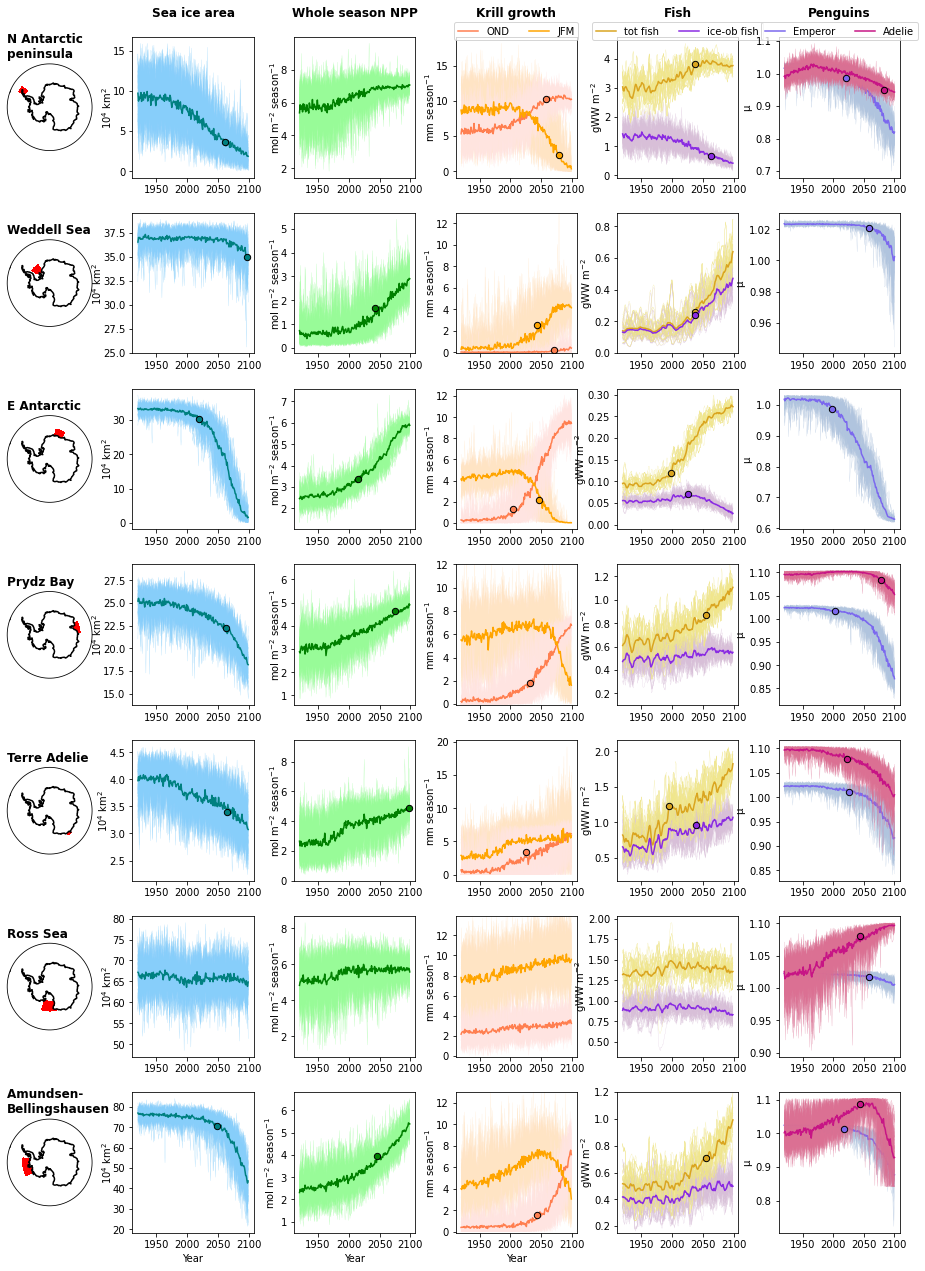

In [55]:
fig = plt.figure(figsize=(16, 22))
gs = gridspec.GridSpec(nrows=7, ncols=6, width_ratios=(0.7, 1, 1, 1, 1,1),height_ratios=(1,1,1,1,1,1,1))
cmap = ListedColormap(name='allred', colors=['red'])
prj =ccrs.SouthPolarStereo()

ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[1, 0], projection=prj)
ax_map3 = plt.subplot(gs[2, 0], projection=prj)
ax_map4 = plt.subplot(gs[3, 0], projection=prj)
ax_map5 = plt.subplot(gs[4, 0], projection=prj)
ax_map6 = plt.subplot(gs[5, 0], projection=prj)
ax_map7 = plt.subplot(gs[6, 0], projection=prj)

ax_SIA1 = plt.subplot(gs[0, 1])
ax_SIA2 = plt.subplot(gs[1, 1])
ax_SIA3 = plt.subplot(gs[2, 1])
ax_SIA4 = plt.subplot(gs[3, 1])
ax_SIA5 = plt.subplot(gs[4, 1])
ax_SIA6 = plt.subplot(gs[5, 1])
ax_SIA7 = plt.subplot(gs[6, 1])

ax_npp1 = plt.subplot(gs[0, 2])
ax_npp2 = plt.subplot(gs[1, 2])
ax_npp3 = plt.subplot(gs[2, 2])
ax_npp4 = plt.subplot(gs[3, 2])
ax_npp5 = plt.subplot(gs[4, 2])
ax_npp6 = plt.subplot(gs[5, 2])
ax_npp7 = plt.subplot(gs[6, 2])

ax_kgp1 = plt.subplot(gs[0, 3])
ax_kgp2 = plt.subplot(gs[1, 3])
ax_kgp3 = plt.subplot(gs[2, 3])
ax_kgp4 = plt.subplot(gs[3, 3])
ax_kgp5 = plt.subplot(gs[4, 3])
ax_kgp6 = plt.subplot(gs[5, 3])
ax_kgp7 = plt.subplot(gs[6, 3])

ax_fish1 = plt.subplot(gs[0, 4])
ax_fish2 = plt.subplot(gs[1, 4])
ax_fish3 = plt.subplot(gs[2, 4])
ax_fish4 = plt.subplot(gs[3, 4])
ax_fish5 = plt.subplot(gs[4, 4])
ax_fish6 = plt.subplot(gs[5, 4])
ax_fish7 = plt.subplot(gs[6, 4])

ax_pen1 = plt.subplot(gs[0, 5])
ax_pen2 = plt.subplot(gs[1, 5])
ax_pen3 = plt.subplot(gs[2, 5])
ax_pen4 = plt.subplot(gs[3, 5])
ax_pen5 = plt.subplot(gs[4, 5])
ax_pen6 = plt.subplot(gs[5, 5])
ax_pen7 = plt.subplot(gs[6, 5])
############ maps ###################################
ax_map1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map1.set_title('N Antarctic \npeninsula', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask1)
pc1 = ax_map1.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.coastlines('110m',linewidth=1.5)

ax_map2.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map2.set_title('Weddell Sea', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask3)
pc1 = ax_map2.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.coastlines('110m',linewidth=1.5)

ax_map3.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map3.set_title('E Antarctic', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask2)
pc1 = ax_map3.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.coastlines('110m',linewidth=1.5)

ax_map4.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map4.set_title('Prydz Bay', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask7)
pc1 = ax_map4.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map4.set_boundary(circle, transform=ax_map4.transAxes)
ax_map4.coastlines('110m',linewidth=1.5)


ax_map5.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map5.set_title('Terre Adelie', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask4)
pc1 = ax_map5.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map5.set_boundary(circle, transform=ax_map5.transAxes)
ax_map5.coastlines('110m',linewidth=1.5)

ax_map6.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map6.set_title('Ross Sea', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask5)
pc1 = ax_map6.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map6.set_boundary(circle, transform=ax_map6.transAxes)
ax_map6.coastlines('110m',linewidth=1.5)

ax_map7.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map7.set_title('Amundsen- \nBellingshausen', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask6)
pc1 = ax_map7.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map7.set_boundary(circle, transform=ax_map7.transAxes)
ax_map7.coastlines('110m',linewidth=1.5)




############ SIA line plots ###################################

ax_SIA1.set_title("Sea ice area", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_SIA1.plot(years, ts_AP['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA1.plot(years, ts_AP['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA1.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA1.scatter(ToE_AP['IFRAC_OND_SIA_km2'],ToEval_AP['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
                
#ax_SIA2.set_title("i) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA2.plot(years, ts_Wedd['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA2.plot(years, ts_Wedd['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA2.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA2.scatter(ToE_Wedd['IFRAC_OND_SIA_km2'],ToEval_Wedd['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)

#ax_SIA3.set_title("m) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA3.plot(years, ts_EAnt['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA3.plot(years, ts_EAnt['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA3.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA3.scatter(ToE_EAnt['IFRAC_OND_SIA_km2'],ToEval_EAnt['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)

#ax_SIA4.set_title("m) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA4.plot(years, ts_Prydz['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA4.plot(years, ts_Prydz['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA4.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA4.scatter(ToE_Prydz['IFRAC_OND_SIA_km2'],ToEval_Prydz['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
#ax_SIA4.set_ylim(0.16,0.28)

#ax_SIA5.set_title("q) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA5.plot(years, ts_Adelie['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA5.plot(years, ts_Adelie['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA5.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
#ax_SIA5.set_xlabel('Year')
ax_SIA5.scatter(ToE_Adelie['IFRAC_OND_SIA_km2'],ToEval_Adelie['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
  
#ax_SIA6.set_title("q) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA6.plot(years, ts_Ross['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA6.plot(years, ts_Ross['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA6.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
#ax_SIA6.set_xlabel('Year')
ax_SIA6.scatter(ToE_Ross['IFRAC_OND_SIA_km2'],ToEval_Ross['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)

#ax_SIA7.set_title("q) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA7.plot(years, ts_AmBel['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA7.plot(years, ts_AmBel['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA7.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA7.set_xlabel('Year')
ax_SIA7.scatter(ToE_AmBel['IFRAC_OND_SIA_km2'],ToEval_AmBel['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
  


# ############ NPP line plots ###################################

ax_npp1.set_title("Whole season NPP", x=0.5, y=1.1, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_npp1.plot(years, ts_AP['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp1.plot(years, ts_AP['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp1.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp1.scatter(ToE_AP['NPP_ONDJFM'],ToEval_AP['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp2.set_title("j) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp2.plot(years, ts_Wedd['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp2.plot(years, ts_Wedd['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp2.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp2.scatter(ToE_Wedd['NPP_ONDJFM'],ToEval_Wedd['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp3.set_title("n) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp3.plot(years, ts_EAnt['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp3.plot(years, ts_EAnt['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp3.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp3.scatter(ToE_EAnt['NPP_ONDJFM'],ToEval_EAnt['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp4.set_title("n) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp4.plot(years, ts_Prydz['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp4.plot(years, ts_Prydz['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp4.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp4.scatter(ToE_Prydz['NPP_ONDJFM'],ToEval_Prydz['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp5.set_title("r) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp5.plot(years, ts_Adelie['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp5.plot(years, ts_Adelie['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp5.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp5.scatter(ToE_Adelie['NPP_ONDJFM'],ToEval_Adelie['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp6.set_title("r) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp6.plot(years, ts_Ross['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp6.plot(years, ts_Ross['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp6.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp6.scatter(ToE_Ross['NPP_ONDJFM'],ToEval_Ross['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp7.set_title("r) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp7.plot(years, ts_AmBel['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp7.plot(years, ts_AmBel['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp7.set_ylabel('mol m$^{-2}$ season$^{-1}$')
ax_npp7.set_xlabel('Year')
ax_npp7.scatter(ToE_AmBel['NPP_ONDJFM'],ToEval_AmBel['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)


# ############ KGP line plots ###################################

ax_kgp1.set_title("Krill growth", y=1.1, x=0.5, fontsize=12, weight='bold',zorder=4)
for mem in np.arange(0,50,1):
    ax_kgp1.plot(years, ts_AP['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp1.plot(years, ts_AP['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp1.plot(years, ts_AP['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp1.plot(years, ts_AP['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
ax_kgp1.legend(bbox_to_anchor=[0.5, 1.04],ncol=2, loc='center' )
ax_kgp1.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp1.scatter(ToE_AP['KGP_OND'],ToEval_AP['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp1.scatter(ToE_AP['KGP_JFM'],ToEval_AP['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp2.set_title("k) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp2.plot(years, ts_Wedd['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp2.plot(years, ts_Wedd['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp2.plot(years, ts_Wedd['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0),
ax_kgp2.plot(years, ts_Wedd['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp2.legend()
ax_kgp2.set_ylim(-0.1,13)
ax_kgp2.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp2.scatter(ToE_Wedd['KGP_OND'],ToEval_Wedd['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp2.scatter(ToE_Wedd['KGP_JFM'],ToEval_Wedd['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)


#ax_kgp3.set_title("o) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp3.plot(years, ts_EAnt['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp3.plot(years, ts_EAnt['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp3.plot(years, ts_EAnt['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp3.plot(years, ts_EAnt['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp3.legend()
ax_kgp3.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp3.scatter(ToE_EAnt['KGP_OND'],ToEval_EAnt['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp3.scatter(ToE_EAnt['KGP_JFM'],ToEval_EAnt['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp4.set_title("o) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp4.plot(years, ts_Prydz['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp4.plot(years, ts_Prydz['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp4.plot(years, ts_Prydz['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp4.plot(years, ts_Prydz['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp3.legend()
ax_kgp4.set_ylim(-0.1,12)
ax_kgp4.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp4.scatter(ToE_Prydz['KGP_OND'],ToEval_Prydz['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp4.scatter(ToE_Prydz['KGP_JFM'],ToEval_Prydz['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp5.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp5.plot(years, ts_Adelie['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp5.plot(years, ts_Adelie['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp5.plot(years, ts_Adelie['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp5.plot(years, ts_Adelie['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp5.legend()
ax_kgp5.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp5.scatter(ToE_Adelie['KGP_OND'],ToEval_Adelie['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp5.scatter(ToE_Adelie['KGP_JFM'],ToEval_Adelie['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp6.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp6.plot(years, ts_Ross['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp6.plot(years, ts_Ross['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp6.plot(years, ts_Ross['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp6.plot(years, ts_Ross['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp6.legend()
ax_kgp6.set_ylim(-0.1,13.9)
ax_kgp6.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp6.scatter(ToE_Ross['KGP_OND'],ToEval_Ross['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp6.scatter(ToE_Ross['KGP_JFM'],ToEval_Ross['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)


#ax_kgp7.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp7.plot(years, ts_AmBel['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp7.plot(years, ts_AmBel['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp7.plot(years, ts_AmBel['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp7.plot(years, ts_AmBel['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp7.legend()
ax_kgp7.set_ylim(-0.1,13)
ax_kgp7.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp7.scatter(ToE_AmBel['KGP_OND'],ToEval_AmBel['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp7.scatter(ToE_AmBel['KGP_JFM'],ToEval_AmBel['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)
ax_kgp7.set_xlabel('Year')

# ############ FISH line plots ###################################

ax_fish1.set_title("Fish", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_fish1.plot(years, ts_AP['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish1.plot(years, ts_AP['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish1.plot(years, ts_AP['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish1.plot(years, ts_AP['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
ax_fish1.legend(bbox_to_anchor=[0.5, 1.04], ncol=2, loc='center')
ax_fish1.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish1.scatter(ToE_AP['total_fish'],ToEval_AP['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish1.scatter(ToE_AP['total_fish_ice'],ToEval_AP['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish2.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish2.plot(years, ts_Wedd['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish2.plot(years, ts_Wedd['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish2.plot(years, ts_Wedd['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish2.plot(years, ts_Wedd['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish2.legend()
ax_fish2.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish2.scatter(ToE_Wedd['total_fish'],ToEval_Wedd['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish2.scatter(ToE_Wedd['total_fish_ice'],ToEval_Wedd['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish3.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish3.plot(years, ts_EAnt['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish3.plot(years, ts_EAnt['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish3.plot(years, ts_EAnt['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish3.plot(years, ts_EAnt['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish3.legend()
ax_fish3.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish3.scatter(ToE_EAnt['total_fish'],ToEval_EAnt['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish3.scatter(ToE_EAnt['total_fish_ice'],ToEval_EAnt['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish4.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish4.plot(years, ts_Prydz['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish4.plot(years, ts_Prydz['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish4.plot(years, ts_Prydz['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish4.plot(years, ts_Prydz['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish4.legend(bbox_to_anchor=[0.25, 0.85] )
ax_fish4.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish4.set_ylim(0.1,1.3)
ax_fish4.scatter(ToE_Prydz['total_fish'],ToEval_Prydz['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish4.scatter(ToE_Prydz['total_fish_ice'],ToEval_Prydz['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish5.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish5.plot(years, ts_Adelie['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish5.plot(years, ts_Adelie['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish5.plot(years, ts_Adelie['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish5.plot(years, ts_Adelie['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish5.legend()
ax_fish5.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish5.scatter(ToE_Adelie['total_fish'],ToEval_Adelie['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish5.scatter(ToE_Adelie['total_fish_ice'],ToEval_Adelie['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish6.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish6.plot(years, ts_Ross['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish6.plot(years, ts_Ross['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish6.plot(years, ts_Ross['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish6.plot(years, ts_Ross['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish6.legend()
ax_fish6.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish6.scatter(ToE_Ross['total_fish'],ToEval_Ross['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish6.scatter(ToE_Ross['total_fish_ice'],ToEval_Ross['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish7.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish7.plot(years, ts_AmBel['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish7.plot(years, ts_AmBel['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish7.plot(years, ts_AmBel['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish7.plot(years, ts_AmBel['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish7.legend()
ax_fish7.set_ylim(0.15,1.2)
ax_fish7.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish7.scatter(ToE_AmBel['total_fish'],ToEval_AmBel['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish7.scatter(ToE_AmBel['total_fish_ice'],ToEval_AmBel['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)



############ Emperor and Adelie line plots ###################################
### AP: Emperor & Adelie
ax_pen1.set_title("Penguins", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_pen1.plot(emp_dict['AP'].time, emp_dict['AP'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen1.plot(emp_dict['AP'].time, emp_dict['AP'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen1.scatter(ToE_AP['Emperor'],ToEval_AP['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_pen1.plot(adelie_dict['AP'].time, adelie_dict['AP'].isel(sim=mem), color='palevioletred',linewidth=0.2)
ax_pen1.plot(adelie_dict['AP'].time, adelie_dict['AP'].mean(dim='sim'),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen1.scatter(ToE_AP['Adelie'],ToEval_AP['Adelie'],s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen1.legend(bbox_to_anchor=[0.5, 1.04], ncol=2, loc='center')
ax_pen1.set_ylabel('µ')

##### Weddell Sea (only Emperor)
for mem in np.arange(0,50,1):
    ax_pen2.plot(emp_dict['Wedd'].time, emp_dict['Wedd'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen2.plot(emp_dict['Wedd'].time, emp_dict['Wedd'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen2.scatter(ToE_Wedd['Emperor'],ToEval_Wedd['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen2.set_ylim(0.45,1.08)
ax_pen2.set_ylabel('µ')

##### Eastern Antarctic region (only Emperor)
for mem in np.arange(0,50,1):
    ax_pen3.plot(emp_dict['EAnt'].time, emp_dict['EAnt'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen3.plot(emp_dict['EAnt'].time, emp_dict['EAnt'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen3.scatter(ToE_EAnt['Emperor'],ToEval_EAnt['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen3.set_ylim(0.45,1.08)
ax_pen3.set_ylabel('µ')

##### Prydz Bay
for mem in np.arange(0,50,1):
    ax_pen4.plot(emp_dict['Prydz'].time, emp_dict['Prydz'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen4.plot(emp_dict['Prydz'].time, emp_dict['Prydz'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen4.scatter(ToE_Prydz['Emperor'],ToEval_Prydz['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen4.plot(adelie_dict['Prydz'].time, adelie_dict['Prydz'].isel(sim=mem), color='palevioletred',linewidth=0.2)
ax_pen4.plot(adelie_dict['Prydz'].time, adelie_dict['Prydz'].mean(dim='sim'),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen4.scatter(ToE_Prydz['Adelie'],ToEval_Prydz['Adelie'],s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen4.set_ylabel('µ')

##### Terre Adelie
for mem in np.arange(0,50,1):
    ax_pen5.plot(emp_dict['Adelie'].time, emp_dict['Adelie'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen5.plot(emp_dict['Adelie'].time, emp_dict['Adelie'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen5.scatter(ToE_Adelie['Emperor'],ToEval_Adelie['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen5.plot(adelie_dict['Adelie'].time, adelie_dict['Adelie'].isel(sim=mem), color='palevioletred',linewidth=0.2)
ax_pen5.plot(adelie_dict['Adelie'].time, adelie_dict['Adelie'].mean(dim='sim'),
           color='mediumvioletred', zorder=2, label='Emperor')
ax_pen5.scatter(ToE_Adelie['Adelie'],ToEval_Adelie['Adelie'],s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen5.set_ylabel('µ')

##### 
for mem in np.arange(0,50,1):
    ax_pen6.plot(emp_dict['Ross'].time, emp_dict['Ross'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen6.plot(emp_dict['Ross'].time, emp_dict['Ross'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen6.scatter(ToE_Ross['Emperor'],ToEval_Ross['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen6.plot(adelie_dict['Ross'].time, adelie_dict['Ross'].isel(sim=mem), color='palevioletred',linewidth=0.2)
ax_pen6.plot(adelie_dict['Ross'].time, adelie_dict['Ross'].mean(dim='sim'),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen6.scatter(ToE_Ross['Adelie'],ToEval_Ross['Adelie'],s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen6.set_ylabel('µ')

##### 
for mem in np.arange(0,50,1):
    ax_pen7.plot(emp_dict['AmBel'].time, emp_dict['AmBel'].isel(sim=mem), color='lightsteelblue',linewidth=0.2)
ax_pen7.plot(emp_dict['AmBel'].time, emp_dict['AmBel'].mean(dim='sim'),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen7.scatter(ToE_AmBel['Emperor'],ToEval_AmBel['Emperor'],s=40,color='mediumslateblue',edgecolor='black',zorder=4)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen7.plot(adelie_dict['AmBel'].time, adelie_dict['AmBel'].isel(sim=mem), color='palevioletred',linewidth=0.2)
ax_pen7.plot(adelie_dict['AmBel'].time, adelie_dict['AmBel'].mean(dim='sim'),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen7.scatter(ToE_AmBel['Adelie'],ToEval_AmBel['Adelie'],s=40,color='mediumvioletred',edgecolor='black',zorder=4)
ax_pen7.set_ylabel('µ')



fig.subplots_adjust(wspace=0.35, hspace=0.25)


#fig.savefig('/glade/work/kristenk/figs/Fig_7regs_timeseries.png', bbox_inches='tight', dpi=300, format='png');

### Try another version with log(µ) for penguin growth rates

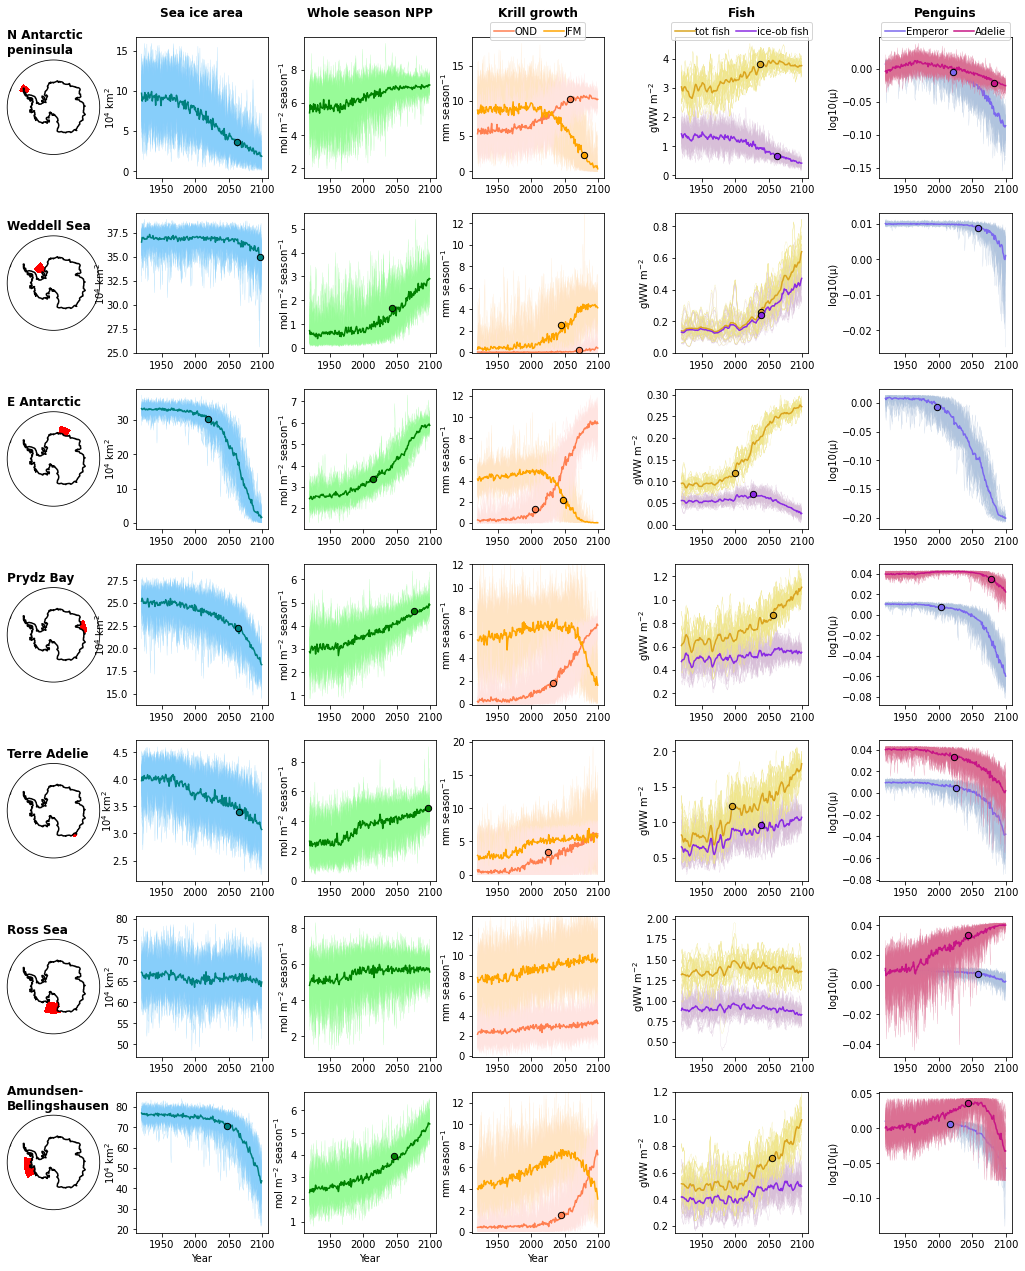

In [56]:
fig = plt.figure(figsize=(18, 22))
gs = gridspec.GridSpec(nrows=7, ncols=8, width_ratios=(0.7, 1, 1, 1,0.001, 1, 0.001,1),height_ratios=(1,1,1,1,1,1,1))
cmap = ListedColormap(name='allred', colors=['red'])
prj =ccrs.SouthPolarStereo()

ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[1, 0], projection=prj)
ax_map3 = plt.subplot(gs[2, 0], projection=prj)
ax_map4 = plt.subplot(gs[3, 0], projection=prj)
ax_map5 = plt.subplot(gs[4, 0], projection=prj)
ax_map6 = plt.subplot(gs[5, 0], projection=prj)
ax_map7 = plt.subplot(gs[6, 0], projection=prj)

ax_SIA1 = plt.subplot(gs[0, 1])
ax_SIA2 = plt.subplot(gs[1, 1])
ax_SIA3 = plt.subplot(gs[2, 1])
ax_SIA4 = plt.subplot(gs[3, 1])
ax_SIA5 = plt.subplot(gs[4, 1])
ax_SIA6 = plt.subplot(gs[5, 1])
ax_SIA7 = plt.subplot(gs[6, 1])

ax_npp1 = plt.subplot(gs[0, 2])
ax_npp2 = plt.subplot(gs[1, 2])
ax_npp3 = plt.subplot(gs[2, 2])
ax_npp4 = plt.subplot(gs[3, 2])
ax_npp5 = plt.subplot(gs[4, 2])
ax_npp6 = plt.subplot(gs[5, 2])
ax_npp7 = plt.subplot(gs[6, 2])

ax_kgp1 = plt.subplot(gs[0, 3])
ax_kgp2 = plt.subplot(gs[1, 3])
ax_kgp3 = plt.subplot(gs[2, 3])
ax_kgp4 = plt.subplot(gs[3, 3])
ax_kgp5 = plt.subplot(gs[4, 3])
ax_kgp6 = plt.subplot(gs[5, 3])
ax_kgp7 = plt.subplot(gs[6, 3])

ax_fish1 = plt.subplot(gs[0, 5])
ax_fish2 = plt.subplot(gs[1, 5])
ax_fish3 = plt.subplot(gs[2, 5])
ax_fish4 = plt.subplot(gs[3, 5])
ax_fish5 = plt.subplot(gs[4, 5])
ax_fish6 = plt.subplot(gs[5, 5])
ax_fish7 = plt.subplot(gs[6, 5])

ax_pen1 = plt.subplot(gs[0, 7])
ax_pen2 = plt.subplot(gs[1, 7])
ax_pen3 = plt.subplot(gs[2, 7])
ax_pen4 = plt.subplot(gs[3, 7])
ax_pen5 = plt.subplot(gs[4, 7])
ax_pen6 = plt.subplot(gs[5, 7])
ax_pen7 = plt.subplot(gs[6, 7])
############ maps ###################################
ax_map1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map1.set_title('N Antarctic \npeninsula', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask1)
pc1 = ax_map1.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.coastlines('110m',linewidth=1.5)

ax_map2.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map2.set_title('Weddell Sea', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask3)
pc1 = ax_map2.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.coastlines('110m',linewidth=1.5)

ax_map3.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map3.set_title('E Antarctic', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask2)
pc1 = ax_map3.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.coastlines('110m',linewidth=1.5)

ax_map4.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map4.set_title('Prydz Bay', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask7)
pc1 = ax_map4.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map4.set_boundary(circle, transform=ax_map4.transAxes)
ax_map4.coastlines('110m',linewidth=1.5)


ax_map5.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map5.set_title('Terre Adelie', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask4)
pc1 = ax_map5.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map5.set_boundary(circle, transform=ax_map5.transAxes)
ax_map5.coastlines('110m',linewidth=1.5)

ax_map6.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map6.set_title('Ross Sea', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask5)
pc1 = ax_map6.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map6.set_boundary(circle, transform=ax_map6.transAxes)
ax_map6.coastlines('110m',linewidth=1.5)

ax_map7.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map7.set_title('Amundsen- \nBellingshausen', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask6)
pc1 = ax_map7.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map7.set_boundary(circle, transform=ax_map7.transAxes)
ax_map7.coastlines('110m',linewidth=1.5)




############ SIA line plots ###################################

ax_SIA1.set_title("Sea ice area", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_SIA1.plot(years, ts_AP['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA1.plot(years, ts_AP['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA1.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA1.scatter(ToE_AP['IFRAC_OND_SIA_km2'],ToEval_AP['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
                
#ax_SIA2.set_title("i) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA2.plot(years, ts_Wedd['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA2.plot(years, ts_Wedd['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA2.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA2.scatter(ToE_Wedd['IFRAC_OND_SIA_km2'],ToEval_Wedd['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)

#ax_SIA3.set_title("m) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA3.plot(years, ts_EAnt['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA3.plot(years, ts_EAnt['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA3.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA3.scatter(ToE_EAnt['IFRAC_OND_SIA_km2'],ToEval_EAnt['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)

#ax_SIA4.set_title("m) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA4.plot(years, ts_Prydz['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA4.plot(years, ts_Prydz['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA4.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA4.scatter(ToE_Prydz['IFRAC_OND_SIA_km2'],ToEval_Prydz['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
#ax_SIA4.set_ylim(0.16,0.28)

#ax_SIA5.set_title("q) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA5.plot(years, ts_Adelie['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA5.plot(years, ts_Adelie['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA5.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
#ax_SIA5.set_xlabel('Year')
ax_SIA5.scatter(ToE_Adelie['IFRAC_OND_SIA_km2'],ToEval_Adelie['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
  
#ax_SIA6.set_title("q) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA6.plot(years, ts_Ross['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA6.plot(years, ts_Ross['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA6.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
#ax_SIA6.set_xlabel('Year')
ax_SIA6.scatter(ToE_Ross['IFRAC_OND_SIA_km2'],ToEval_Ross['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)

#ax_SIA7.set_title("q) Sea ice area", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_SIA7.plot(years, ts_AmBel['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2)
ax_SIA7.plot(years, ts_AmBel['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=2)
ax_SIA7.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA7.set_xlabel('Year')
ax_SIA7.scatter(ToE_AmBel['IFRAC_OND_SIA_km2'],ToEval_AmBel['IFRAC_OND_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=3)
  


# ############ NPP line plots ###################################

ax_npp1.set_title("Whole season NPP", x=0.5, y=1.1, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_npp1.plot(years, ts_AP['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp1.plot(years, ts_AP['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp1.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp1.scatter(ToE_AP['NPP_ONDJFM'],ToEval_AP['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp2.set_title("j) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp2.plot(years, ts_Wedd['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp2.plot(years, ts_Wedd['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp2.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp2.scatter(ToE_Wedd['NPP_ONDJFM'],ToEval_Wedd['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp3.set_title("n) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp3.plot(years, ts_EAnt['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp3.plot(years, ts_EAnt['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp3.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp3.scatter(ToE_EAnt['NPP_ONDJFM'],ToEval_EAnt['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp4.set_title("n) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp4.plot(years, ts_Prydz['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp4.plot(years, ts_Prydz['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp4.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp4.scatter(ToE_Prydz['NPP_ONDJFM'],ToEval_Prydz['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp5.set_title("r) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp5.plot(years, ts_Adelie['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp5.plot(years, ts_Adelie['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp5.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp5.scatter(ToE_Adelie['NPP_ONDJFM'],ToEval_Adelie['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp6.set_title("r) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp6.plot(years, ts_Ross['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp6.plot(years, ts_Ross['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp6.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp6.scatter(ToE_Ross['NPP_ONDJFM'],ToEval_Ross['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)

#ax_npp7.set_title("r) Whole season NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_npp7.plot(years, ts_AmBel['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
ax_npp7.plot(years, ts_AmBel['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
ax_npp7.set_ylabel('mol m$^{-2}$ season$^{-1}$')
ax_npp7.set_xlabel('Year')
ax_npp7.scatter(ToE_AmBel['NPP_ONDJFM'],ToEval_AmBel['NPP_ONDJFM']*0.001,s=40,color='green',edgecolor='black',zorder=3)


# ############ KGP line plots ###################################

ax_kgp1.set_title("Krill growth", y=1.1, x=0.5, fontsize=12, weight='bold',zorder=4)
for mem in np.arange(0,50,1):
    ax_kgp1.plot(years, ts_AP['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp1.plot(years, ts_AP['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp1.plot(years, ts_AP['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp1.plot(years, ts_AP['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
ax_kgp1.legend(bbox_to_anchor=[0.5, 1.04],ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)
ax_kgp1.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp1.scatter(ToE_AP['KGP_OND'],ToEval_AP['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp1.scatter(ToE_AP['KGP_JFM'],ToEval_AP['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp2.set_title("k) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp2.plot(years, ts_Wedd['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp2.plot(years, ts_Wedd['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp2.plot(years, ts_Wedd['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0),
ax_kgp2.plot(years, ts_Wedd['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp2.legend()
ax_kgp2.set_ylim(-0.1,13)
ax_kgp2.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp2.scatter(ToE_Wedd['KGP_OND'],ToEval_Wedd['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp2.scatter(ToE_Wedd['KGP_JFM'],ToEval_Wedd['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)


#ax_kgp3.set_title("o) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp3.plot(years, ts_EAnt['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp3.plot(years, ts_EAnt['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp3.plot(years, ts_EAnt['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp3.plot(years, ts_EAnt['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp3.legend()
ax_kgp3.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp3.scatter(ToE_EAnt['KGP_OND'],ToEval_EAnt['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp3.scatter(ToE_EAnt['KGP_JFM'],ToEval_EAnt['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp4.set_title("o) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp4.plot(years, ts_Prydz['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp4.plot(years, ts_Prydz['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp4.plot(years, ts_Prydz['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp4.plot(years, ts_Prydz['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp3.legend()
ax_kgp4.set_ylim(-0.1,12)
ax_kgp4.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp4.scatter(ToE_Prydz['KGP_OND'],ToEval_Prydz['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp4.scatter(ToE_Prydz['KGP_JFM'],ToEval_Prydz['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp5.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp5.plot(years, ts_Adelie['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp5.plot(years, ts_Adelie['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp5.plot(years, ts_Adelie['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp5.plot(years, ts_Adelie['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp5.legend()
ax_kgp5.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp5.scatter(ToE_Adelie['KGP_OND'],ToEval_Adelie['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp5.scatter(ToE_Adelie['KGP_JFM'],ToEval_Adelie['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp6.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp6.plot(years, ts_Ross['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp6.plot(years, ts_Ross['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp6.plot(years, ts_Ross['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp6.plot(years, ts_Ross['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp6.legend()
ax_kgp6.set_ylim(-0.1,13.9)
ax_kgp6.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp6.scatter(ToE_Ross['KGP_OND'],ToEval_Ross['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp6.scatter(ToE_Ross['KGP_JFM'],ToEval_Ross['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)


#ax_kgp7.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp7.plot(years, ts_AmBel['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp7.plot(years, ts_AmBel['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp7.plot(years, ts_AmBel['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp7.plot(years, ts_AmBel['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp7.legend()
ax_kgp7.set_ylim(-0.1,13)
ax_kgp7.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp7.scatter(ToE_AmBel['KGP_OND'],ToEval_AmBel['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp7.scatter(ToE_AmBel['KGP_JFM'],ToEval_AmBel['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)
ax_kgp7.set_xlabel('Year')

# ############ FISH line plots ###################################

ax_fish1.set_title("Fish", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_fish1.plot(years, ts_AP['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish1.plot(years, ts_AP['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish1.plot(years, ts_AP['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish1.plot(years, ts_AP['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
ax_fish1.legend(bbox_to_anchor=[0.5, 1.04], ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)
ax_fish1.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish1.scatter(ToE_AP['total_fish'],ToEval_AP['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish1.scatter(ToE_AP['total_fish_ice'],ToEval_AP['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish2.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish2.plot(years, ts_Wedd['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish2.plot(years, ts_Wedd['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish2.plot(years, ts_Wedd['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish2.plot(years, ts_Wedd['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish2.legend()
ax_fish2.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish2.scatter(ToE_Wedd['total_fish'],ToEval_Wedd['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish2.scatter(ToE_Wedd['total_fish_ice'],ToEval_Wedd['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish3.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish3.plot(years, ts_EAnt['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish3.plot(years, ts_EAnt['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish3.plot(years, ts_EAnt['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish3.plot(years, ts_EAnt['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish3.legend()
ax_fish3.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish3.scatter(ToE_EAnt['total_fish'],ToEval_EAnt['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish3.scatter(ToE_EAnt['total_fish_ice'],ToEval_EAnt['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish4.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish4.plot(years, ts_Prydz['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish4.plot(years, ts_Prydz['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish4.plot(years, ts_Prydz['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish4.plot(years, ts_Prydz['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish4.legend(bbox_to_anchor=[0.25, 0.85] )
ax_fish4.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish4.set_ylim(0.1,1.3)
ax_fish4.scatter(ToE_Prydz['total_fish'],ToEval_Prydz['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish4.scatter(ToE_Prydz['total_fish_ice'],ToEval_Prydz['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish5.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish5.plot(years, ts_Adelie['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish5.plot(years, ts_Adelie['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish5.plot(years, ts_Adelie['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish5.plot(years, ts_Adelie['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish5.legend()
ax_fish5.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish5.scatter(ToE_Adelie['total_fish'],ToEval_Adelie['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish5.scatter(ToE_Adelie['total_fish_ice'],ToEval_Adelie['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish6.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish6.plot(years, ts_Ross['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish6.plot(years, ts_Ross['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish6.plot(years, ts_Ross['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish6.plot(years, ts_Ross['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish6.legend()
ax_fish6.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish6.scatter(ToE_Ross['total_fish'],ToEval_Ross['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish6.scatter(ToE_Ross['total_fish_ice'],ToEval_Ross['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish7.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish7.plot(years, ts_AmBel['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish7.plot(years, ts_AmBel['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish7.plot(years, ts_AmBel['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish7.plot(years, ts_AmBel['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish7.legend()
ax_fish7.set_ylim(0.15,1.2)
ax_fish7.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish7.scatter(ToE_AmBel['total_fish'],ToEval_AmBel['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish7.scatter(ToE_AmBel['total_fish_ice'],ToEval_AmBel['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)



############ Emperor and Adelie line plots ###################################
### AP: Emperor & Adelie
ax_pen1.set_title("Penguins", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_pen1.plot(emp_dict['AP'].time, np.log10(emp_dict['AP'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen1.plot(emp_dict['AP'].time, np.log10(emp_dict['AP'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen1.scatter(ToE_AP['Emperor'],np.log10(ToEval_AP['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_pen1.plot(adelie_dict['AP'].time, np.log10(adelie_dict['AP'].isel(sim=mem)), color='palevioletred',linewidth=0.2)
ax_pen1.plot(adelie_dict['AP'].time, np.log10(adelie_dict['AP'].mean(dim='sim')),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen1.scatter(ToE_AP['Adelie'],np.log10(ToEval_AP['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen1.legend(bbox_to_anchor=[0.5, 1.04], ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)
ax_pen1.set_ylabel('log10(µ)')

##### Weddell Sea (only Emperor)
for mem in np.arange(0,50,1):
    ax_pen2.plot(emp_dict['Wedd'].time, np.log10(emp_dict['Wedd'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen2.plot(emp_dict['Wedd'].time, np.log10(emp_dict['Wedd'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen2.scatter(ToE_Wedd['Emperor'],np.log10(ToEval_Wedd['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen2.set_ylim(0.45,1.08)
ax_pen2.set_ylabel('log10(µ)')

##### Eastern Antarctic region (only Emperor)
for mem in np.arange(0,50,1):
    ax_pen3.plot(emp_dict['EAnt'].time, np.log10(emp_dict['EAnt'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen3.plot(emp_dict['EAnt'].time, np.log10(emp_dict['EAnt'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen3.scatter(ToE_EAnt['Emperor'],np.log10(ToEval_EAnt['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen3.set_ylim(0.45,1.08)
ax_pen3.set_ylabel('log10(µ)')

##### Prydz Bay
for mem in np.arange(0,50,1):
    ax_pen4.plot(emp_dict['Prydz'].time, np.log10(emp_dict['Prydz'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen4.plot(emp_dict['Prydz'].time, np.log10(emp_dict['Prydz'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen4.scatter(ToE_Prydz['Emperor'],np.log10(ToEval_Prydz['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen4.plot(adelie_dict['Prydz'].time, np.log10(adelie_dict['Prydz'].isel(sim=mem)), color='palevioletred',linewidth=0.2)
ax_pen4.plot(adelie_dict['Prydz'].time, np.log10(adelie_dict['Prydz'].mean(dim='sim')),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen4.scatter(ToE_Prydz['Adelie'],np.log10(ToEval_Prydz['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen4.set_ylabel('log10(µ)')

##### Terre Adelie
for mem in np.arange(0,50,1):
    ax_pen5.plot(emp_dict['Adelie'].time, np.log10(emp_dict['Adelie'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen5.plot(emp_dict['Adelie'].time, np.log10(emp_dict['Adelie'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen5.scatter(ToE_Adelie['Emperor'],np.log10(ToEval_Adelie['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen5.plot(adelie_dict['Adelie'].time, np.log10(adelie_dict['Adelie'].isel(sim=mem)), color='palevioletred',linewidth=0.2)
ax_pen5.plot(adelie_dict['Adelie'].time, np.log10(adelie_dict['Adelie'].mean(dim='sim')),
           color='mediumvioletred', zorder=2, label='Emperor')
ax_pen5.scatter(ToE_Adelie['Adelie'],np.log10(ToEval_Adelie['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen5.set_ylabel('log10(µ)')

##### 
for mem in np.arange(0,50,1):
    ax_pen6.plot(emp_dict['Ross'].time, np.log10(emp_dict['Ross'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen6.plot(emp_dict['Ross'].time, np.log10(emp_dict['Ross'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen6.scatter(ToE_Ross['Emperor'],np.log10(ToEval_Ross['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen6.plot(adelie_dict['Ross'].time, np.log10(adelie_dict['Ross'].isel(sim=mem)), color='palevioletred',linewidth=0.2)
ax_pen6.plot(adelie_dict['Ross'].time, np.log10(adelie_dict['Ross'].mean(dim='sim')),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen6.scatter(ToE_Ross['Adelie'],np.log10(ToEval_Ross['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen6.set_ylabel('log10(µ)')

##### 
for mem in np.arange(0,50,1):
    ax_pen7.plot(emp_dict['AmBel'].time, np.log10(emp_dict['AmBel'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen7.plot(emp_dict['AmBel'].time, np.log10(emp_dict['AmBel'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen7.scatter(ToE_AmBel['Emperor'],np.log10(ToEval_AmBel['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen7.plot(adelie_dict['AmBel'].time, np.log10(adelie_dict['AmBel'].isel(sim=mem)), color='palevioletred',linewidth=0.2)
ax_pen7.plot(adelie_dict['AmBel'].time, np.log10(adelie_dict['AmBel'].mean(dim='sim')),
           color='mediumvioletred', zorder=2, label='Adelie')
ax_pen7.scatter(ToE_AmBel['Adelie'],np.log10(ToEval_AmBel['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=3)
ax_pen7.set_ylabel('log10(µ)')



fig.subplots_adjust(wspace=0.38, hspace=0.25)


fig.savefig('/glade/work/kristenk/figs/Fig_7regs_timeseries.png', bbox_inches='tight', dpi=300, format='png');

### Split up SIA and NPP into OND and JFM components

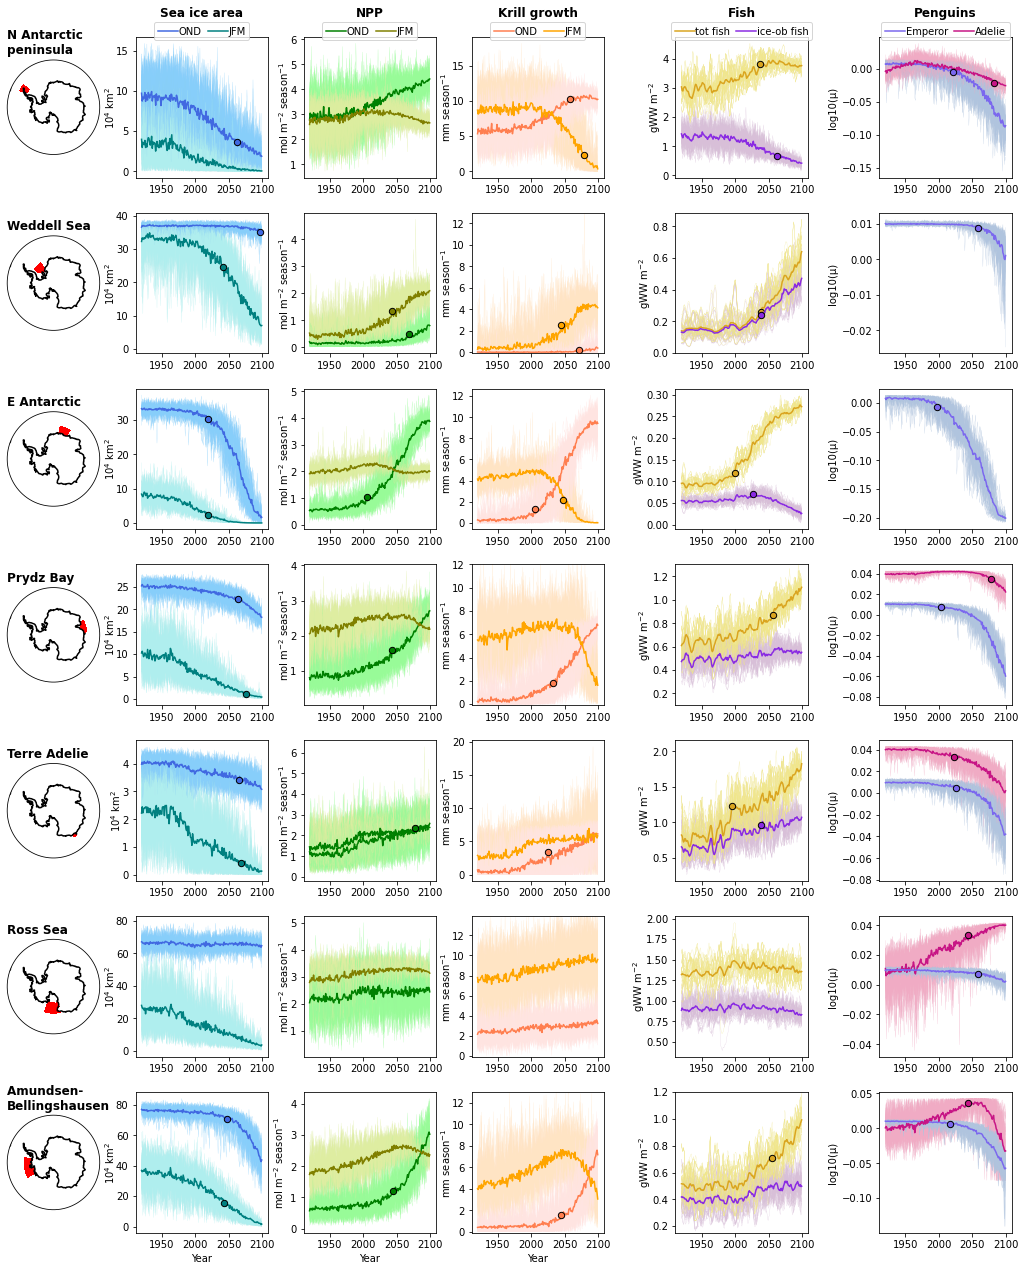

In [57]:
fig = plt.figure(figsize=(18, 22))
gs = gridspec.GridSpec(nrows=7, ncols=8, width_ratios=(0.7, 1, 1, 1,0.001, 1, 0.001,1),height_ratios=(1,1,1,1,1,1,1))
cmap = ListedColormap(name='allred', colors=['red'])
prj =ccrs.SouthPolarStereo()

ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[1, 0], projection=prj)
ax_map3 = plt.subplot(gs[2, 0], projection=prj)
ax_map4 = plt.subplot(gs[3, 0], projection=prj)
ax_map5 = plt.subplot(gs[4, 0], projection=prj)
ax_map6 = plt.subplot(gs[5, 0], projection=prj)
ax_map7 = plt.subplot(gs[6, 0], projection=prj)

ax_SIA1 = plt.subplot(gs[0, 1])
ax_SIA2 = plt.subplot(gs[1, 1])
ax_SIA3 = plt.subplot(gs[2, 1])
ax_SIA4 = plt.subplot(gs[3, 1])
ax_SIA5 = plt.subplot(gs[4, 1])
ax_SIA6 = plt.subplot(gs[5, 1])
ax_SIA7 = plt.subplot(gs[6, 1])

ax_npp1 = plt.subplot(gs[0, 2])
ax_npp2 = plt.subplot(gs[1, 2])
ax_npp3 = plt.subplot(gs[2, 2])
ax_npp4 = plt.subplot(gs[3, 2])
ax_npp5 = plt.subplot(gs[4, 2])
ax_npp6 = plt.subplot(gs[5, 2])
ax_npp7 = plt.subplot(gs[6, 2])

ax_kgp1 = plt.subplot(gs[0, 3])
ax_kgp2 = plt.subplot(gs[1, 3])
ax_kgp3 = plt.subplot(gs[2, 3])
ax_kgp4 = plt.subplot(gs[3, 3])
ax_kgp5 = plt.subplot(gs[4, 3])
ax_kgp6 = plt.subplot(gs[5, 3])
ax_kgp7 = plt.subplot(gs[6, 3])

ax_fish1 = plt.subplot(gs[0, 5])
ax_fish2 = plt.subplot(gs[1, 5])
ax_fish3 = plt.subplot(gs[2, 5])
ax_fish4 = plt.subplot(gs[3, 5])
ax_fish5 = plt.subplot(gs[4, 5])
ax_fish6 = plt.subplot(gs[5, 5])
ax_fish7 = plt.subplot(gs[6, 5])

ax_pen1 = plt.subplot(gs[0, 7])
ax_pen2 = plt.subplot(gs[1, 7])
ax_pen3 = plt.subplot(gs[2, 7])
ax_pen4 = plt.subplot(gs[3, 7])
ax_pen5 = plt.subplot(gs[4, 7])
ax_pen6 = plt.subplot(gs[5, 7])
ax_pen7 = plt.subplot(gs[6, 7])
############ maps ###################################
ax_map1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map1.set_title('N Antarctic \npeninsula', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask1)
pc1 = ax_map1.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.coastlines('110m',linewidth=1.5)

ax_map2.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map2.set_title('Weddell Sea', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask3)
pc1 = ax_map2.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.coastlines('110m',linewidth=1.5)

ax_map3.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map3.set_title('E Antarctic', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask2)
pc1 = ax_map3.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.coastlines('110m',linewidth=1.5)

ax_map4.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map4.set_title('Prydz Bay', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask7)
pc1 = ax_map4.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map4.set_boundary(circle, transform=ax_map4.transAxes)
ax_map4.coastlines('110m',linewidth=1.5)


ax_map5.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map5.set_title('Terre Adelie', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask4)
pc1 = ax_map5.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map5.set_boundary(circle, transform=ax_map5.transAxes)
ax_map5.coastlines('110m',linewidth=1.5)

ax_map6.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map6.set_title('Ross Sea', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask5)
pc1 = ax_map6.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map6.set_boundary(circle, transform=ax_map6.transAxes)
ax_map6.coastlines('110m',linewidth=1.5)

ax_map7.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map7.set_title('Amundsen- \nBellingshausen', loc='left',weight='bold')
lon,lat,field = utils.adjust_pop_grid(lons, lats, mask6)
pc1 = ax_map7.pcolormesh(lon,lat,field,transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),vmin=0,vmax=1)
ax_map7.set_boundary(circle, transform=ax_map7.transAxes)
ax_map7.coastlines('110m',linewidth=1.5)




############ SIA line plots ###################################

ax_SIA1.set_title("Sea ice area", y=1.1, x=0.5, fontsize=12, weight='bold')
z = 0 
for mem in np.arange(0,50,1):
    ax_SIA1.plot(years, ts_AP['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA1.plot(years, ts_AP['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53, label='OND')
ax_SIA1.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA1.scatter(ToE_AP['IFRAC_OND_SIA_km2'],ToEval_AP['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0 
for mem in np.arange(0,50,1):
    ax_SIA1.plot(years, ts_AP['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA1.plot(years, ts_AP['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53, label='JFM')
ax_SIA1.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA1.scatter(ToE_AP['IFRAC_JFM_SIA_km2'],ToEval_AP['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)
ax_SIA1.legend(bbox_to_anchor=[0.5, 1.04],ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)


#ax_SIA2.set_title("i) Sea ice area", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA2.plot(years, ts_Wedd['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA2.plot(years, ts_Wedd['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53)
ax_SIA2.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA2.scatter(ToE_Wedd['IFRAC_OND_SIA_km2'],ToEval_Wedd['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA2.plot(years, ts_Wedd['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA2.plot(years, ts_Wedd['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53, label='JFM')
ax_SIA2.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA2.scatter(ToE_Wedd['IFRAC_JFM_SIA_km2'],ToEval_Wedd['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)


#ax_SIA3.set_title("m) Sea ice area", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA3.plot(years, ts_EAnt['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA3.plot(years, ts_EAnt['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53)
ax_SIA3.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA3.scatter(ToE_EAnt['IFRAC_OND_SIA_km2'],ToEval_EAnt['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA3.plot(years, ts_EAnt['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA3.plot(years, ts_EAnt['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53)
ax_SIA3.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA3.scatter(ToE_EAnt['IFRAC_JFM_SIA_km2'],ToEval_EAnt['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)



#ax_SIA4.set_title("m) Sea ice area", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA4.plot(years, ts_Prydz['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA4.plot(years, ts_Prydz['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53)
ax_SIA4.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA4.scatter(ToE_Prydz['IFRAC_OND_SIA_km2'],ToEval_Prydz['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA4.plot(years, ts_Prydz['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA4.plot(years, ts_Prydz['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53)
ax_SIA4.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA4.scatter(ToE_Prydz['IFRAC_JFM_SIA_km2'],ToEval_Prydz['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)



#ax_SIA5.set_title("q) Sea ice area", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA5.plot(years, ts_Adelie['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA5.plot(years, ts_Adelie['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53)
ax_SIA5.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
#ax_SIA5.set_xlabel('Year')
ax_SIA5.scatter(ToE_Adelie['IFRAC_OND_SIA_km2'],ToEval_Adelie['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA5.plot(years, ts_Adelie['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA5.plot(years, ts_Adelie['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53)
ax_SIA5.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
#ax_SIA5.set_xlabel('Year')
ax_SIA5.scatter(ToE_Adelie['IFRAC_JFM_SIA_km2'],ToEval_Adelie['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)
  
#ax_SIA6.set_title("q) Sea ice area", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA6.plot(years, ts_Ross['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA6.plot(years, ts_Ross['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53)
ax_SIA6.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA6.scatter(ToE_Ross['IFRAC_OND_SIA_km2'],ToEval_Ross['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA6.plot(years, ts_Ross['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA6.plot(years, ts_Ross['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53)
ax_SIA6.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA6.scatter(ToE_Ross['IFRAC_JFM_SIA_km2'],ToEval_Ross['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)

#ax_SIA7.set_title("q) Sea ice area", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA7.plot(years, ts_AmBel['IFRAC_OND_SIA_km2'].isel(member_id=mem)*1e-4, color='lightskyblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA7.plot(years, ts_AmBel['IFRAC_OND_SIA_km2'].mean(dim='member_id')*1e-4,
           color='royalblue', zorder=53)
ax_SIA7.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA7.set_xlabel('Year')
ax_SIA7.scatter(ToE_AmBel['IFRAC_OND_SIA_km2'],ToEval_AmBel['IFRAC_OND_SIA_km2']*1e-4,s=40,color='royalblue',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_SIA7.plot(years, ts_AmBel['IFRAC_JFM_SIA_km2'].isel(member_id=mem)*1e-4, color='paleturquoise',linewidth=0.2,zorder=z)
    z = z + 1
ax_SIA7.plot(years, ts_AmBel['IFRAC_JFM_SIA_km2'].mean(dim='member_id')*1e-4,
           color='teal', zorder=53)
ax_SIA7.set_ylabel('10$^4$ km$^{2}$', labelpad=-1)
ax_SIA7.set_xlabel('Year')
ax_SIA7.scatter(ToE_AmBel['IFRAC_JFM_SIA_km2'],ToEval_AmBel['IFRAC_JFM_SIA_km2']*1e-4,s=40,color='teal',edgecolor='black',zorder=54)


# ############ NPP line plots ###################################

ax_npp1.set_title("NPP", x=0.5, y=1.1, fontsize=12, weight='bold')
z = 0 
for mem in np.arange(0,50,1):
    ax_npp1.plot(years, ts_AP['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2, zorder=z)
    z = z + 1
ax_npp1.plot(years, ts_AP['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53,label='OND')
ax_npp1.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp1.scatter(ToE_AP['NPP_OND'],ToEval_AP['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)
#z = 0 
for mem in np.arange(0,50,1):
    ax_npp1.plot(years, ts_AP['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2, zorder=52)
    #z = z + 1
ax_npp1.plot(years, ts_AP['NPP_JFM'].mean(dim='member_id')*0.001,
           color='olive', zorder=53,label='JFM')
ax_npp1.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp1.scatter(ToE_AP['NPP_JFM'],ToEval_AP['NPP_JFM']*0.001,s=40,color='olive',edgecolor='black',zorder=54)

ax_npp1.legend(bbox_to_anchor=[0.5, 1.04],ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)



#ax_npp2.set_title("j) Whole season NPP", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_npp2.plot(years, ts_Wedd['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2,zorder=z)
    z = z + 1
ax_npp2.plot(years, ts_Wedd['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp2.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp2.scatter(ToE_Wedd['NPP_OND'],ToEval_Wedd['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)

z = 0
for mem in np.arange(0,50,1):
    ax_npp2.plot(years, ts_Wedd['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_npp2.plot(years, ts_Wedd['NPP_JFM'].mean(dim='member_id')*0.001,
           color='olive', zorder=53)
ax_npp2.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp2.scatter(ToE_Wedd['NPP_JFM'],ToEval_Wedd['NPP_JFM']*0.001,s=40,color='olive',edgecolor='black',zorder=54)




#ax_npp3.set_title("n) Whole season NPP", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_npp3.plot(years, ts_EAnt['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2,zorder=z)
    z = z + 1
ax_npp3.plot(years, ts_EAnt['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp3.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp3.scatter(ToE_EAnt['NPP_OND'],ToEval_EAnt['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_npp3.plot(years, ts_EAnt['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_npp3.plot(years, ts_EAnt['NPP_JFM'].mean(dim='member_id')*0.001,
           color='olive', zorder=53)
ax_npp3.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp3.scatter(ToE_EAnt['NPP_JFM'],ToEval_EAnt['NPP_JFM']*0.001,s=40,color='olive',edgecolor='black',zorder=54)





#ax_npp4.set_title("n) Whole season NPP", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_npp4.plot(years, ts_Prydz['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2,zorder=z)
    z = z + 1
ax_npp4.plot(years, ts_Prydz['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp4.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp4.scatter(ToE_Prydz['NPP_OND'],ToEval_Prydz['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_npp4.plot(years, ts_Prydz['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_npp4.plot(years, ts_Prydz['NPP_JFM'].mean(dim='member_id')*0.001,
           color='olive', zorder=53)
ax_npp4.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp4.scatter(ToE_Prydz['NPP_JFM'],ToEval_Prydz['NPP_JFM']*0.001,s=40,color='olive',edgecolor='black',zorder=54)



#ax_npp5.set_title("r) Whole season NPP", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_npp5.plot(years, ts_Adelie['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2,zorder=z)
    z = z + 1
ax_npp5.plot(years, ts_Adelie['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp5.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp5.scatter(ToE_Adelie['NPP_OND'],ToEval_Adelie['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_npp5.plot(years, ts_Adelie['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_npp5.plot(years, ts_Adelie['NPP_JFM'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp5.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp5.scatter(ToE_Adelie['NPP_JFM'],ToEval_Adelie['NPP_JFM']*0.001,s=40,color='green',edgecolor='black',zorder=54)



#ax_npp6.set_title("r) Whole season NPP", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_npp6.plot(years, ts_Ross['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2,zorder=z)
    z = z + 1
ax_npp6.plot(years, ts_Ross['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp6.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp6.scatter(ToE_Ross['NPP_OND'],ToEval_Ross['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_npp6.plot(years, ts_Ross['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_npp6.plot(years, ts_Ross['NPP_JFM'].mean(dim='member_id')*0.001,
           color='olive', zorder=53)
ax_npp6.set_ylabel('mol m$^{-2}$ season$^{-1}$', labelpad=-1)
ax_npp6.scatter(ToE_Ross['NPP_JFM'],ToEval_Ross['NPP_JFM']*0.001,s=40,color='olive',edgecolor='black',zorder=54)

#ax_npp7.set_title("r) Whole season NPP", loc="left", fontsize=12)
z = 0
for mem in np.arange(0,50,1):
    ax_npp7.plot(years, ts_AmBel['NPP_OND'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2,zorder=z)
    z = z + 1
ax_npp7.plot(years, ts_AmBel['NPP_OND'].mean(dim='member_id')*0.001,
           color='green', zorder=53)
ax_npp7.set_ylabel('mol m$^{-2}$ season$^{-1}$')
ax_npp7.set_xlabel('Year')
ax_npp7.scatter(ToE_AmBel['NPP_OND'],ToEval_AmBel['NPP_OND']*0.001,s=40,color='green',edgecolor='black',zorder=54)
z = 0
for mem in np.arange(0,50,1):
    ax_npp7.plot(years, ts_AmBel['NPP_JFM'].isel(member_id=mem)*0.001, color=(222/255,237/255,161/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_npp7.plot(years, ts_AmBel['NPP_JFM'].mean(dim='member_id')*0.001,
           color='olive', zorder=53)
ax_npp7.set_ylabel('mol m$^{-2}$ season$^{-1}$')
ax_npp7.set_xlabel('Year')
ax_npp7.scatter(ToE_AmBel['NPP_JFM'],ToEval_AmBel['NPP_JFM']*0.001,s=40,color='olive',edgecolor='black',zorder=54)

# ############ KGP line plots ###################################

ax_kgp1.set_title("Krill growth", y=1.1, x=0.5, fontsize=12, weight='bold',zorder=4)
for mem in np.arange(0,50,1):
    ax_kgp1.plot(years, ts_AP['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp1.plot(years, ts_AP['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp1.plot(years, ts_AP['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp1.plot(years, ts_AP['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
ax_kgp1.legend(bbox_to_anchor=[0.5, 1.04],ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)
ax_kgp1.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp1.scatter(ToE_AP['KGP_OND'],ToEval_AP['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp1.scatter(ToE_AP['KGP_JFM'],ToEval_AP['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp2.set_title("k) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp2.plot(years, ts_Wedd['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp2.plot(years, ts_Wedd['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp2.plot(years, ts_Wedd['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0),
ax_kgp2.plot(years, ts_Wedd['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp2.legend()
ax_kgp2.set_ylim(-0.1,13)
ax_kgp2.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp2.scatter(ToE_Wedd['KGP_OND'],ToEval_Wedd['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp2.scatter(ToE_Wedd['KGP_JFM'],ToEval_Wedd['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)


#ax_kgp3.set_title("o) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp3.plot(years, ts_EAnt['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp3.plot(years, ts_EAnt['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp3.plot(years, ts_EAnt['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp3.plot(years, ts_EAnt['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp3.legend()
ax_kgp3.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp3.scatter(ToE_EAnt['KGP_OND'],ToEval_EAnt['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp3.scatter(ToE_EAnt['KGP_JFM'],ToEval_EAnt['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp4.set_title("o) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp4.plot(years, ts_Prydz['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp4.plot(years, ts_Prydz['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp4.plot(years, ts_Prydz['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp4.plot(years, ts_Prydz['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp3.legend()
ax_kgp4.set_ylim(-0.1,12)
ax_kgp4.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp4.scatter(ToE_Prydz['KGP_OND'],ToEval_Prydz['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp4.scatter(ToE_Prydz['KGP_JFM'],ToEval_Prydz['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp5.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp5.plot(years, ts_Adelie['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp5.plot(years, ts_Adelie['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp5.plot(years, ts_Adelie['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp5.plot(years, ts_Adelie['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp5.legend()
ax_kgp5.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp5.scatter(ToE_Adelie['KGP_OND'],ToEval_Adelie['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp5.scatter(ToE_Adelie['KGP_JFM'],ToEval_Adelie['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)

#ax_kgp6.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp6.plot(years, ts_Ross['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp6.plot(years, ts_Ross['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp6.plot(years, ts_Ross['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp6.plot(years, ts_Ross['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp6.legend()
ax_kgp6.set_ylim(-0.1,13.9)
ax_kgp6.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp6.scatter(ToE_Ross['KGP_OND'],ToEval_Ross['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp6.scatter(ToE_Ross['KGP_JFM'],ToEval_Ross['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)


#ax_kgp7.set_title("s) Krill growth", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_kgp7.plot(years, ts_AmBel['KGP_OND'].isel(member_id=mem), color='mistyrose',linewidth=0.2,zorder=1)
ax_kgp7.plot(years, ts_AmBel['KGP_OND'].mean(dim='member_id'),
           color='coral', zorder=2,label='OND')
for mem in np.arange(0,50,1):
    ax_kgp7.plot(years, ts_AmBel['KGP_JFM'].isel(member_id=mem), color='bisque',linewidth=0.2,zorder=0)
ax_kgp7.plot(years, ts_AmBel['KGP_JFM'].mean(dim='member_id'),
           color='orange', zorder=3,label='JFM')
#ax_kgp7.legend()
ax_kgp7.set_ylim(-0.1,13)
ax_kgp7.set_ylabel('mm season$^{-1}$', labelpad=-1)
ax_kgp7.scatter(ToE_AmBel['KGP_OND'],ToEval_AmBel['KGP_OND'],s=40,color='coral',edgecolor='black',zorder=3)
ax_kgp7.scatter(ToE_AmBel['KGP_JFM'],ToEval_AmBel['KGP_JFM'],s=40,color='orange',edgecolor='black',zorder=4)
ax_kgp7.set_xlabel('Year')

# ############ FISH line plots ###################################

ax_fish1.set_title("Fish", y=1.1, x=0.5, fontsize=12, weight='bold')
for mem in np.arange(0,50,1):
    ax_fish1.plot(years, ts_AP['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish1.plot(years, ts_AP['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish1.plot(years, ts_AP['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish1.plot(years, ts_AP['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
ax_fish1.legend(bbox_to_anchor=[0.5, 1.04], ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)
ax_fish1.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish1.scatter(ToE_AP['total_fish'],ToEval_AP['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish1.scatter(ToE_AP['total_fish_ice'],ToEval_AP['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish2.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish2.plot(years, ts_Wedd['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish2.plot(years, ts_Wedd['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish2.plot(years, ts_Wedd['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish2.plot(years, ts_Wedd['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish2.legend()
ax_fish2.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish2.scatter(ToE_Wedd['total_fish'],ToEval_Wedd['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish2.scatter(ToE_Wedd['total_fish_ice'],ToEval_Wedd['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish3.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish3.plot(years, ts_EAnt['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish3.plot(years, ts_EAnt['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish3.plot(years, ts_EAnt['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish3.plot(years, ts_EAnt['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish3.legend()
ax_fish3.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish3.scatter(ToE_EAnt['total_fish'],ToEval_EAnt['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish3.scatter(ToE_EAnt['total_fish_ice'],ToEval_EAnt['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish4.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish4.plot(years, ts_Prydz['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish4.plot(years, ts_Prydz['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish4.plot(years, ts_Prydz['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish4.plot(years, ts_Prydz['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish4.legend(bbox_to_anchor=[0.25, 0.85] )
ax_fish4.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish4.set_ylim(0.1,1.3)
ax_fish4.scatter(ToE_Prydz['total_fish'],ToEval_Prydz['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish4.scatter(ToE_Prydz['total_fish_ice'],ToEval_Prydz['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish5.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish5.plot(years, ts_Adelie['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish5.plot(years, ts_Adelie['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish5.plot(years, ts_Adelie['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish5.plot(years, ts_Adelie['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish5.legend()
ax_fish5.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish5.scatter(ToE_Adelie['total_fish'],ToEval_Adelie['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish5.scatter(ToE_Adelie['total_fish_ice'],ToEval_Adelie['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish6.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish6.plot(years, ts_Ross['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish6.plot(years, ts_Ross['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish6.plot(years, ts_Ross['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish6.plot(years, ts_Ross['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish6.legend()
ax_fish6.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish6.scatter(ToE_Ross['total_fish'],ToEval_Ross['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish6.scatter(ToE_Ross['total_fish_ice'],ToEval_Ross['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)

#ax_fish7.set_title("g) Fish", loc="left", fontsize=12)
for mem in np.arange(0,50,1):
    ax_fish7.plot(years, ts_AmBel['total_fish'].isel(member_id=mem), color='khaki',linewidth=0.2,zorder=1)
ax_fish7.plot(years, ts_AmBel['total_fish'].mean(dim='member_id'),
           color='goldenrod', zorder=2,label='tot fish')
for mem in np.arange(0,50,1):
    ax_fish7.plot(years, ts_AmBel['total_fish_ice'].isel(member_id=mem), color='thistle',linewidth=0.2,zorder=0)
ax_fish7.plot(years, ts_AmBel['total_fish_ice'].mean(dim='member_id'),
           color='blueviolet', zorder=3,label='ice-ob fish')
#ax_fish7.legend()
ax_fish7.set_ylim(0.15,1.2)
ax_fish7.set_ylabel('gWW m$^{-2}$', labelpad=-1)
ax_fish7.scatter(ToE_AmBel['total_fish'],ToEval_AmBel['total_fish'],s=40,color='goldenrod',edgecolor='black',zorder=3)
ax_fish7.scatter(ToE_AmBel['total_fish_ice'],ToEval_AmBel['total_fish_ice'],s=40,color='blueviolet',edgecolor='black',zorder=4)



############ Emperor and Adelie line plots ###################################
### AP: Emperor & Adelie
ax_pen1.set_title("Penguins", y=1.1, x=0.5, fontsize=12, weight='bold')
z=0
for mem in np.arange(0,50,1):
    ax_pen1.plot(emp_dict['AP'].time, np.log10(emp_dict['AP'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2, zorder=z)
    z = z + 1
ax_pen1.plot(emp_dict['AP'].time, np.log10(emp_dict['AP'].mean(dim='sim')),
           color='mediumslateblue', zorder=53, label='Emperor')
ax_pen1.scatter(ToE_AP['Emperor'],np.log10(ToEval_AP['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=54)

z=0
for mem in np.arange(0,50,1):
    ax_pen1.plot(adelie_dict['AP'].time, np.log10(adelie_dict['AP'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_pen1.plot(adelie_dict['AP'].time, np.log10(adelie_dict['AP'].mean(dim='sim')),
           color='mediumvioletred', zorder=53, label='Adelie')
ax_pen1.scatter(ToE_AP['Adelie'],np.log10(ToEval_AP['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=54)
ax_pen1.legend(bbox_to_anchor=[0.5, 1.04], ncol=2, loc='center',columnspacing=0.6,handletextpad=0.05)
ax_pen1.set_ylabel('log10(µ)')

##### Weddell Sea (only Emperor)
for mem in np.arange(0,50,1):
    ax_pen2.plot(emp_dict['Wedd'].time, np.log10(emp_dict['Wedd'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen2.plot(emp_dict['Wedd'].time, np.log10(emp_dict['Wedd'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen2.scatter(ToE_Wedd['Emperor'],np.log10(ToEval_Wedd['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen2.set_ylim(0.45,1.08)
ax_pen2.set_ylabel('log10(µ)')

##### Eastern Antarctic region (only Emperor)
for mem in np.arange(0,50,1):
    ax_pen3.plot(emp_dict['EAnt'].time, np.log10(emp_dict['EAnt'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2)
ax_pen3.plot(emp_dict['EAnt'].time, np.log10(emp_dict['EAnt'].mean(dim='sim')),
           color='mediumslateblue', zorder=2, label='Emperor')
ax_pen3.scatter(ToE_EAnt['Emperor'],np.log10(ToEval_EAnt['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=3)
#ax_pen3.set_ylim(0.45,1.08)
ax_pen3.set_ylabel('log10(µ)')

##### Prydz Bay
z = 0
for mem in np.arange(0,50,1):
    ax_pen4.plot(emp_dict['Prydz'].time, np.log10(emp_dict['Prydz'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2, zorder=z)
    z = z + 1
ax_pen4.plot(emp_dict['Prydz'].time, np.log10(emp_dict['Prydz'].mean(dim='sim')),
           color='mediumslateblue', zorder=53, label='Emperor')
ax_pen4.scatter(ToE_Prydz['Emperor'],np.log10(ToEval_Prydz['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=54)
#ax_pen4.set_ylim(0.45,1.08)
z = 0
for mem in np.arange(0,50,1):
    ax_pen4.plot(adelie_dict['Prydz'].time, np.log10(adelie_dict['Prydz'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_pen4.plot(adelie_dict['Prydz'].time, np.log10(adelie_dict['Prydz'].mean(dim='sim')),
           color='mediumvioletred', zorder=53, label='Adelie')
ax_pen4.scatter(ToE_Prydz['Adelie'],np.log10(ToEval_Prydz['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=54)
ax_pen4.set_ylabel('log10(µ)')

##### Terre Adelie
z = 0
for mem in np.arange(0,50,1):
    ax_pen5.plot(emp_dict['Adelie'].time, np.log10(emp_dict['Adelie'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2,zorder=z)
    z = z + 1
ax_pen5.plot(emp_dict['Adelie'].time, np.log10(emp_dict['Adelie'].mean(dim='sim')),
           color='mediumslateblue', zorder=54, label='Emperor')
ax_pen5.scatter(ToE_Adelie['Emperor'],np.log10(ToEval_Adelie['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=55)
#ax_pen4.set_ylim(0.45,1.08)
z = 0
for mem in np.arange(0,50,1):
    ax_pen5.plot(adelie_dict['Adelie'].time, np.log10(adelie_dict['Adelie'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2, zorder=z)
    z = z + 1
ax_pen5.plot(adelie_dict['Adelie'].time, np.log10(adelie_dict['Adelie'].mean(dim='sim')),
           color='mediumvioletred', zorder=53, label='Emperor')
ax_pen5.scatter(ToE_Adelie['Adelie'],np.log10(ToEval_Adelie['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=55)
ax_pen5.set_ylabel('log10(µ)')

##### 
for mem in np.arange(0,50,1):
    ax_pen6.plot(emp_dict['Ross'].time, np.log10(emp_dict['Ross'].isel(sim=mem)), color='lightsteelblue',linewidth=0.2,zorder=3)
ax_pen6.plot(emp_dict['Ross'].time, np.log10(emp_dict['Ross'].mean(dim='sim')),
           color='mediumslateblue', zorder=4, label='Emperor')
ax_pen6.scatter(ToE_Ross['Emperor'],np.log10(ToEval_Ross['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=5)
#ax_pen4.set_ylim(0.45,1.08)
for mem in np.arange(0,50,1):
    ax_pen6.plot(adelie_dict['Ross'].time, np.log10(adelie_dict['Ross'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2,zorder=2)
ax_pen6.plot(adelie_dict['Ross'].time, np.log10(adelie_dict['Ross'].mean(dim='sim')),
           color='mediumvioletred', zorder=3, label='Adelie')
ax_pen6.scatter(ToE_Ross['Adelie'],np.log10(ToEval_Ross['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=5)
ax_pen6.set_ylabel('log10(µ)')

##### 
z = 0
for mem in np.arange(0,50,1):
    ax_pen7.plot(emp_dict['AmBel'].time, np.log10(emp_dict['AmBel'].isel(sim=mem)), color='lightsteelblue',linewidth=0.4,zorder=51)
    z = z + 1
ax_pen7.plot(emp_dict['AmBel'].time, np.log10(emp_dict['AmBel'].mean(dim='sim')),
           color='mediumslateblue', zorder=53, label='Emperor')
ax_pen7.scatter(ToE_AmBel['Emperor'],np.log10(ToEval_AmBel['Emperor']),s=40,color='mediumslateblue',edgecolor='black',zorder=54)
#ax_pen4.set_ylim(0.45,1.08)
z = 0
for mem in np.arange(0,50,1):
    ax_pen7.plot(adelie_dict['AmBel'].time, np.log10(adelie_dict['AmBel'].isel(sim=mem)), color=(240/255,171/255,196/255),linewidth=0.2,zorder=z)
    z = z + 1
ax_pen7.plot(adelie_dict['AmBel'].time, np.log10(adelie_dict['AmBel'].mean(dim='sim')),
           color='mediumvioletred', zorder=53, label='Adelie')
ax_pen7.scatter(ToE_AmBel['Adelie'],np.log10(ToEval_AmBel['Adelie']),s=40,color='mediumvioletred',edgecolor='black',zorder=54)
ax_pen7.set_ylabel('log10(µ)')



fig.subplots_adjust(wspace=0.38, hspace=0.25)


fig.savefig('/glade/work/kristenk/figs/Fig3_7regs_timeseries.png', bbox_inches='tight', dpi=300, format='png');

### Map for methods schematic

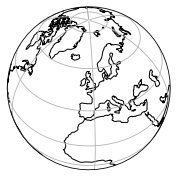

In [57]:
plt.figure(figsize=(3, 3))
ax = plt.axes(projection=ccrs.NearsidePerspective(satellite_height=10000000.0, central_longitude=-3.53, central_latitude=50.72))
ax.coastlines(resolution='110m')
ax.gridlines()

In [60]:
ds_tmp = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-annual-mean-IFRAC.nc')
ds_tmp2 = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/NPP_annual_means_1850-2100.nc')

In [61]:
ds_grid2 = pop_tools.get_grid('POP_gx1v7')
lats2 = ds_grid2.TLAT
lons2 = ds_grid2.TLONG
area2 = ds_grid2.TAREA
lons_norm2 = utils.normal_lons(lons2)

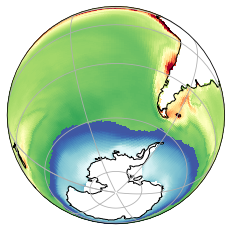

In [62]:
plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.NearsidePerspective(satellite_height=10000000.0, central_longitude=-100, central_latitude=-59))
ax.coastlines(resolution='110m')
lon,lat,field = utils.adjust_pop_grid(lons2, lats2, (ds_tmp.IFRAC.isel(time=100,member_id=10)))

pc1 = ax.pcolormesh(lon,lat,field *100,
                    transform=ccrs.PlateCarree(),
                   cmap=cmocean.cm.ice,vmin=-60,vmax=100)

npp = ds_tmp2.photoC_TOT_zint.isel(time=100,member_id=10).where(ds_tmp.IFRAC.isel(time=100,member_id=10) == 0)
lon,lat,field = utils.adjust_pop_grid(lons2, lats2, npp)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='RdYlGn_r',vmin=0,vmax=80)

ax.gridlines()

In [63]:
variables = ['IFRAC_OND_SIA_km2','IFRAC_JFM_SIA_km2',
             'KGP_OND','KGP_JFM','NPP_OND','NPP_JFM','total_fish','total_fish_ice','Emperor','Adelie']

In [64]:
len(variables)

10

In [65]:
# Suppress scientific notation
np.set_printoptions(suppress=True)

In [66]:
basemean_SIZ

<xarray.Dataset>
Dimensions:               ()
Data variables: (12/13)
    IFRAC_OND_SIA_km2     float64 1.189e+07
    IFRAC_JFM_SIA_km2     float64 3.358e+06
    IFRAC_ONDJFM_SIA_km2  float64 7.673e+06
    Emperor               float64 1.023
    Adelie                float64 0.9614
    KGP_ONDJFM            float64 6.74
    ...                    ...
    KGP_JFM               float64 4.914
    NPP_ONDJFM            float64 3.257e+03
    NPP_OND               float64 1.229e+03
    NPP_JFM               float64 2.028e+03
    total_fish            float64 0.4053
    total_fish_ice        float64 0.2122

### Whole SIZ

In [67]:
df_SIZ = pd.DataFrame(columns=['ToE metric','year','direction_change', 'base_mean', 'coeff_var']) 

i=0
for var in variables:

    if ToEval_SIZ[var] > basemean_SIZ[var]:
        change = 1
    elif ToEval_SIZ[var] < basemean_SIZ[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_SIZ[var].values,3)
    coeffvar = basestd_SIZ[var].values/basemean_SIZ[var].values

    df_SIZ.loc[i] = [var,np.float(ToE_SIZ[var].values), change, mean, coeffvar]

    i = i + 1
df_SIZ.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
9,Adelie,1968.0,1,9.610000e-01,0.023262
6,total_fish,1986.0,1,4.050000e-01,0.042793
0,IFRAC_OND_SIA_km2,1992.0,-1,1.189312e+07,0.025138
1,IFRAC_JFM_SIA_km2,1995.0,-1,3.358172e+06,0.129744
8,Emperor,1996.0,-1,1.023000e+00,0.001839
4,NPP_OND,1998.0,1,1.228669e+03,0.094766
2,KGP_OND,2008.0,1,1.939000e+00,0.205586
3,KGP_JFM,2087.0,-1,4.914000e+00,0.114288
5,NPP_JFM,NaN,0,2.028358e+03,0.063524
7,total_fish_ice,NaN,0,2.120000e-01,0.062764


### AP

In [68]:
df_AP = pd.DataFrame(columns=['ToE metric','year','direction_change', 'base_mean', 'coeff_var']) 

i=0
for var in variables:

    if ToEval_AP[var] > basemean_AP[var]:
        change = 1
    elif ToEval_AP[var] < basemean_AP[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_AP[var].values,3)
    coeffvar = basestd_AP[var].values/basemean_AP[var].values
    
    df_AP.loc[i] = [var,np.float(ToE_AP[var].values), change, mean, coeffvar]

    i = i + 1
    
df_AP.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
8,Emperor,2021.0,-1,1.018,0.014220
6,total_fish,2037.0,1,2.912,0.147343
2,KGP_OND,2058.0,1,5.760,0.374050
0,IFRAC_OND_SIA_km2,2062.0,-1,92225.418,0.304500
7,total_fish_ice,2063.0,-1,1.327,0.251401
3,KGP_JFM,2079.0,-1,8.757,0.355774
9,Adelie,2083.0,-1,1.003,0.023642
1,IFRAC_JFM_SIA_km2,NaN,-1,34390.414,0.833009
4,NPP_OND,NaN,0,2926.552,0.298529
5,NPP_JFM,NaN,0,2782.069,0.224630


### Weddell

In [69]:
df_Wedd = pd.DataFrame(columns=['ToE metric','year','direction_change', 'base_mean', 'coeff_var']) 

i=0
for var in variables[0:9]:

    if ToEval_Wedd[var] > basemean_Wedd[var]:
        change = 1
    elif ToEval_Wedd[var] < basemean_Wedd[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_Wedd[var].values,3)
    coeffvar = basestd_Wedd[var].values/basemean_Wedd[var].values

    df_Wedd.loc[i] = [var,np.float(ToE_Wedd[var].values),change, mean, coeffvar]

    i = i + 1
    
df_Wedd.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
6,total_fish,2038.0,1,0.153,0.323413
7,total_fish_ice,2038.0,1,0.143,0.326661
1,IFRAC_JFM_SIA_km2,2042.0,-1,333277.924,0.129515
5,NPP_JFM,2043.0,1,439.300,0.902066
3,KGP_JFM,2044.0,1,0.372,2.187585
8,Emperor,2059.0,-1,1.023,0.000901
4,NPP_OND,2068.0,1,150.640,1.079504
2,KGP_OND,2071.0,1,0.019,5.820608
0,IFRAC_OND_SIA_km2,2097.0,-1,369553.345,0.026165


### Eastern Antarctic

In [70]:
df_EAnt = pd.DataFrame(columns=['ToE metric','year','direction_change', 'base_mean', 'coeff_var']) 

i=0
for var in variables[0:9]:

    if ToEval_EAnt[var] > basemean_EAnt[var]:
        change = 1
    elif ToEval_EAnt[var] < basemean_EAnt[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_EAnt[var].values,3)
    coeffvar = basestd_EAnt[var].values/basemean_EAnt[var].values

    df_EAnt.loc[i] = [var,np.float(ToE_EAnt[var].values),change, mean, coeffvar]

    i = i + 1
    
df_EAnt.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
8,Emperor,1998.0,-1,1.018,0.015056
6,total_fish,1999.0,1,0.092,0.143033
2,KGP_OND,2005.0,1,0.255,1.901578
4,NPP_OND,2005.0,1,566.409,0.404951
0,IFRAC_OND_SIA_km2,2019.0,-1,331106.456,0.044485
1,IFRAC_JFM_SIA_km2,2019.0,-1,79561.450,0.348041
7,total_fish_ice,2026.0,1,0.054,0.166893
3,KGP_JFM,2047.0,-1,4.305,0.209347
5,NPP_JFM,NaN,0,1983.349,0.134956


### Prydz Bay

In [71]:
df_Prydz = pd.DataFrame(columns=['ToE metric','year','direction_change','base_mean', 'coeff_var']) 

i=0
for var in variables:

    if ToEval_Prydz[var] > basemean_Prydz[var]:
        change = 1
    elif ToEval_Prydz[var] < basemean_Prydz[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_Prydz[var].values,3)
    coeffvar = basestd_Prydz[var].values/basemean_Prydz[var].values

    df_Prydz.loc[i] = [var,np.float(ToE_Prydz[var].values),change, mean, coeffvar]

    i = i + 1
    
df_Prydz.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
8,Emperor,2003.0,-1,1.024,0.003536
2,KGP_OND,2032.0,1,0.326,2.150714
4,NPP_OND,2043.0,1,867.053,0.406189
6,total_fish,2056.0,1,0.636,0.180991
0,IFRAC_OND_SIA_km2,2063.0,-1,250254.154,0.056138
1,IFRAC_JFM_SIA_km2,2075.0,-1,96427.689,0.439899
9,Adelie,2078.0,-1,1.096,0.005366
3,KGP_JFM,NaN,0,5.693,0.360703
5,NPP_JFM,NaN,0,2177.458,0.224604
7,total_fish_ice,NaN,0,0.489,0.199037


### Terre Adelie

In [72]:
df_Adelie = pd.DataFrame(columns=['ToE metric','year','direction_change','base_mean', 'coeff_var']) 

i=0
for var in variables:

    if ToEval_Adelie[var] > basemean_Adelie[var]:
        change = 1
    elif ToEval_Adelie[var] < basemean_Adelie[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_Adelie[var].values,3)
    coeffvar = basestd_Adelie[var].values/basemean_Adelie[var].values
    
    df_Adelie.loc[i] = [var,np.float(ToE_Adelie[var].values),change, mean, coeffvar]

    i = i + 1
    
df_Adelie.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
6,total_fish,1995.0,1,0.774,0.247659
9,Adelie,2023.0,-1,1.097,0.007103
2,KGP_OND,2025.0,1,0.450,2.669470
8,Emperor,2026.0,-1,1.023,0.005311
7,total_fish_ice,2039.0,1,0.624,0.256613
0,IFRAC_OND_SIA_km2,2065.0,-1,40166.195,0.076845
1,IFRAC_JFM_SIA_km2,2068.0,-1,22958.968,0.412048
4,NPP_OND,2077.0,1,1106.219,0.554841
3,KGP_JFM,NaN,0,2.726,0.823032
5,NPP_JFM,NaN,0,1436.215,0.500932


### Ross Sea

In [73]:
df_Ross = pd.DataFrame(columns=['ToE metric','year','direction_change','base_mean', 'coeff_var']) 

i=0
for var in variables:

    if ToEval_Ross[var] > basemean_Ross[var]:
        change = 1
    elif ToEval_Ross[var] < basemean_Ross[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_Ross[var].values,3)
    coeffvar = basestd_Ross[var].values/basemean_Ross[var].values

    df_Ross.loc[i] = [var,np.float(ToE_Ross[var].values),change, mean, coeffvar]

    i = i + 1
    
df_Ross.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
9,Adelie,2043.0,1,1.022,0.026811
8,Emperor,2058.0,-1,1.023,0.002932
0,IFRAC_OND_SIA_km2,NaN,-1,664669.764,0.059331
1,IFRAC_JFM_SIA_km2,NaN,-1,255733.265,0.468417
2,KGP_OND,NaN,0,2.394,0.396584
3,KGP_JFM,NaN,0,7.684,0.285927
4,NPP_OND,NaN,0,2189.660,0.286146
5,NPP_JFM,NaN,0,2907.405,0.185555
6,total_fish,NaN,0,1.329,0.110476
7,total_fish_ice,NaN,0,0.898,0.124845


### Amundsen-Bellinghausen

In [74]:
df_AmBel = pd.DataFrame(columns=['ToE metric','year','direction_change','base_mean', 'coeff_var']) 

i=0
for var in variables:

    if ToEval_AmBel[var] > basemean_AmBel[var]:
        change = 1
    elif ToEval_AmBel[var] < basemean_AmBel[var]:
        change = -1
    else:
        change = 0

    mean = np.round(basemean_AmBel[var].values,3)
    coeffvar = basestd_AmBel[var].values/basemean_AmBel[var].values

    df_AmBel.loc[i] = [var,np.float(ToE_AmBel[var].values),change, mean, coeffvar]

    i = i + 1
    
df_AmBel.sort_values(by=['year'], ascending=True, na_position='last')

,ToE metric,year,direction_change,base_mean,coeff_var
8,Emperor,2017.0,-1,1.023,0.004202
1,IFRAC_JFM_SIA_km2,2043.0,-1,356170.957,0.280950
2,KGP_OND,2044.0,1,0.428,1.026800
4,NPP_OND,2044.0,1,641.226,0.443777
9,Adelie,2044.0,1,1.002,0.042411
0,IFRAC_OND_SIA_km2,2048.0,-1,763027.518,0.038572
6,total_fish,2055.0,1,0.493,0.216774
3,KGP_JFM,NaN,0,4.380,0.408972
5,NPP_JFM,NaN,0,1836.403,0.231266
7,total_fish_ice,NaN,0,0.395,0.239714


### Make a bar graph of SIA variability in each region

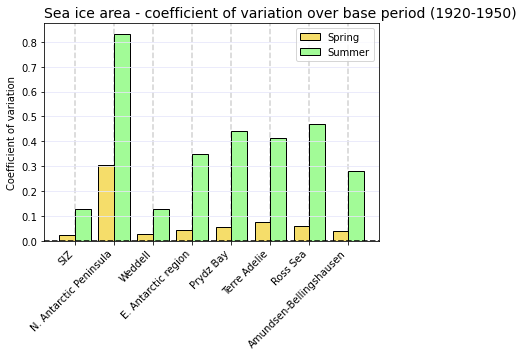

In [75]:
fig = plt.figure(figsize=(6,4))

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'IFRAC_OND_SIA_km2'
valsOND = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

var = 'IFRAC_JFM_SIA_km2'
valsJFM = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

ax = fig.add_subplot(1,1,1)

ax.bar(inds-0.2, valsOND, color=(245/255,221/255,106/255),width=0.4, label='Spring', edgecolor='black')
ax.bar(inds+0.2, valsJFM, color=(162/255,251/255,151/255),width=0.4, label='Summer', edgecolor='black')
ax.set_title('Sea ice area - coefficient of variation over base period (1920-1950)',fontsize=14,loc='left')
ax.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in inds:
    ax.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax.legend()
ax.yaxis.grid(True, which='major',color='lavender')
fig.savefig('/glade/work/kristenk/figs/FigS7_coeff_var_SIA_baseperiod.png', bbox_inches='tight', dpi=300, format='png');

### Now combine this with the model validation figure for the satellite era

In [76]:
ds_regs_ONDstd_cdr = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_ONDstd_cdr.nc')
ds_regs_ONDmean_cdr = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_ONDmean_cdr.nc')

ds_regs_JFMstd_cdr = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_JFMstd_cdr.nc')
ds_regs_JFMmean_cdr = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_JFMmean_cdr.nc')

ds_regs_ONDstd_cesm = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_ONDstd_cesm.nc')
ds_regs_ONDmean_cesm = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_ONDmean_cesm.nc')

ds_regs_JFMstd_cesm = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_JFMstd_cesm.nc')
ds_regs_JFMmean_cesm = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/reg_data/ds_regs_JFMmean_cesm.nc')

## Figure A10

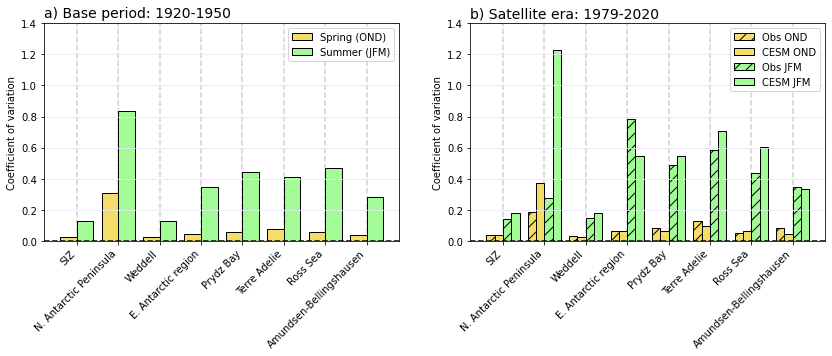

In [77]:
fig = plt.figure(figsize=(14,4))

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'IFRAC_OND_SIA_km2'
valsOND = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

var = 'IFRAC_JFM_SIA_km2'
valsJFM = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

ax = fig.add_subplot(1,2,1)

ax.bar(inds-0.2, valsOND, color=(245/255,221/255,106/255),width=0.4, label='Spring (OND)', edgecolor='black')
ax.bar(inds+0.2, valsJFM, color=(162/255,251/255,151/255),width=0.4, label='Summer (JFM)', edgecolor='black')
ax.set_title('a) Base period: 1920-1950',fontsize=14,loc='left')
ax.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in inds:
    ax.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax.legend()
ax.yaxis.grid(True, which='major',color='lavender')

ax.set_ylim(0,1.4)
############# SATELLITE ERA
spr_color = (245/255,221/255,106/255)

sum_color = (162/255,251/255,151/255)

var = 'sic_ond_SIA_km2'
valsONDcdr = [ds_regs_ONDstd_cdr['SIZ'].values/ds_regs_ONDmean_cdr['SIZ'].values,
       ds_regs_ONDstd_cdr['AP'].values/ds_regs_ONDmean_cdr['AP'].values,
       ds_regs_ONDstd_cdr['Wedd'].values/ds_regs_ONDmean_cdr['Wedd'].values,
       ds_regs_ONDstd_cdr['EAnt'].values/ds_regs_ONDmean_cdr['EAnt'].values,
       ds_regs_ONDstd_cdr['Prydz'].values/ds_regs_ONDmean_cdr['Prydz'].values,
       ds_regs_ONDstd_cdr['Adelie'].values/ds_regs_ONDmean_cdr['Adelie'].values,
       ds_regs_ONDstd_cdr['Ross'].values/ds_regs_ONDmean_cdr['Ross'].values,
       ds_regs_ONDstd_cdr['AmBel'].values/ds_regs_ONDmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsONDcesm = [ds_regs_ONDstd_cesm['SIZ'].values/ds_regs_ONDmean_cesm['SIZ'].values,
       ds_regs_ONDstd_cesm['AP'].values/ds_regs_ONDmean_cesm['AP'].values,
       ds_regs_ONDstd_cesm['Wedd'].values/ds_regs_ONDmean_cesm['Wedd'].values,
       ds_regs_ONDstd_cesm['EAnt'].values/ds_regs_ONDmean_cesm['EAnt'].values,
       ds_regs_ONDstd_cesm['Prydz'].values/ds_regs_ONDmean_cesm['Prydz'].values,
       ds_regs_ONDstd_cesm['Adelie'].values/ds_regs_ONDmean_cesm['Adelie'].values,
       ds_regs_ONDstd_cesm['Ross'].values/ds_regs_ONDmean_cesm['Ross'].values,
       ds_regs_ONDstd_cesm['AmBel'].values/ds_regs_ONDmean_cesm['AmBel'].values]

var = 'sic_jfm_SIA_km2'
valsJFMcdr = [ds_regs_JFMstd_cdr['SIZ'].values/ds_regs_JFMmean_cdr['SIZ'].values,
       ds_regs_JFMstd_cdr['AP'].values/ds_regs_JFMmean_cdr['AP'].values,
       ds_regs_JFMstd_cdr['Wedd'].values/ds_regs_JFMmean_cdr['Wedd'].values,
       ds_regs_JFMstd_cdr['EAnt'].values/ds_regs_JFMmean_cdr['EAnt'].values,
       ds_regs_JFMstd_cdr['Prydz'].values/ds_regs_JFMmean_cdr['Prydz'].values,
       ds_regs_JFMstd_cdr['Adelie'].values/ds_regs_JFMmean_cdr['Adelie'].values,
       ds_regs_JFMstd_cdr['Ross'].values/ds_regs_JFMmean_cdr['Ross'].values,
       ds_regs_JFMstd_cdr['AmBel'].values/ds_regs_JFMmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsJFMcesm = [ds_regs_JFMstd_cesm['SIZ'].values/ds_regs_JFMmean_cesm['SIZ'].values,
       ds_regs_JFMstd_cesm['AP'].values/ds_regs_JFMmean_cesm['AP'].values,
       ds_regs_JFMstd_cesm['Wedd'].values/ds_regs_JFMmean_cesm['Wedd'].values,
       ds_regs_JFMstd_cesm['EAnt'].values/ds_regs_JFMmean_cesm['EAnt'].values,
       ds_regs_JFMstd_cesm['Prydz'].values/ds_regs_JFMmean_cesm['Prydz'].values,
       ds_regs_JFMstd_cesm['Adelie'].values/ds_regs_JFMmean_cesm['Adelie'].values,
       ds_regs_JFMstd_cesm['Ross'].values/ds_regs_JFMmean_cesm['Ross'].values,
       ds_regs_JFMstd_cesm['AmBel'].values/ds_regs_JFMmean_cesm['AmBel'].values]

ax = fig.add_subplot(1,2,2)
ax.yaxis.grid(True, which='major',color='lavender')
ax.bar(inds-0.3, valsONDcdr, color=spr_color,width=0.2, edgecolor='black', hatch='//', label='Obs OND')
ax.bar(inds-0.1, valsONDcesm, color=spr_color,width=0.2, edgecolor='black', label='CESM OND')
ax.bar(inds+0.1, valsJFMcdr, color=sum_color,width=0.2, edgecolor='black', hatch='//', label='Obs JFM')
ax.bar(inds+0.3, valsJFMcesm, color=sum_color,width=0.2, edgecolor='black', label='CESM JFM')


ax.set_title('b) Satellite era: 1979-2020',fontsize=14,loc='left')
ax.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in inds:
    ax.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax.legend()

ax.set_ylim(0,1.4)

fig.savefig('/glade/work/kristenk/figs/FigS10_coeff_var_SIA_regs_obs-model.png', bbox_inches='tight', dpi=300, format='png');

In [78]:
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator

#### Trying to get another version of the figure with equal width bars, but I can't get the x-axis lab

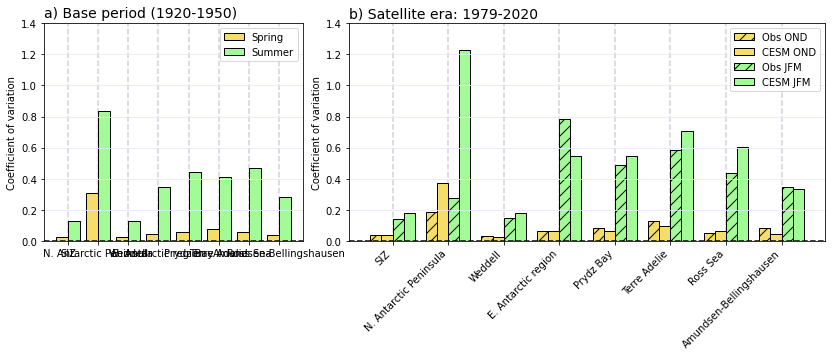

In [77]:
fig = plt.figure(figsize=(14,4))

gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=(1.2, 1, 1))


ax_base = plt.subplot(gs[0, 0])
ax_sat = plt.subplot(gs[0, 1:3])

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'IFRAC_OND_SIA_km2'
valsOND = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

var = 'IFRAC_JFM_SIA_km2'
valsJFM = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

ax_base.bar(inds-0.2, valsOND, color=(245/255,221/255,106/255),width=0.4, label='Spring', edgecolor='black')
ax_base.bar(inds+0.2, valsJFM, color=(162/255,251/255,151/255),width=0.4, label='Summer', edgecolor='black')
ax_base.set_title('a) Base period (1920-1950)',fontsize=14,loc='left')
ax_base.set_ylabel('Coefficient of variation')


#ax_base.xaxis.set_major_locator(MaxNLocator(8))
#plt.xticks(inds, labels,rotation=45, ha='right');
ticker.FixedLocator(inds)
ax_base.locator_params(axis='x', nbins=10)
ax_base.set_xticks(inds);ax_base.set_xticklabels(labels)
#ax_base.tick_params(axis='x', labelrotation=45) # Rotate x-axis labels



ax_base.axhline(0,linestyle='--',color='black')
ax_base.set_ylim(0,1.4)
for i in inds:
    ax_base.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax_base.legend()
ax_base.yaxis.grid(True, which='major',color='lavender')


############# SATELLITE ERA
spr_color = (245/255,221/255,106/255)

sum_color = (162/255,251/255,151/255)

var = 'sic_ond_SIA_km2'
valsONDcdr = [ds_regs_ONDstd_cdr['SIZ'].values/ds_regs_ONDmean_cdr['SIZ'].values,
       ds_regs_ONDstd_cdr['AP'].values/ds_regs_ONDmean_cdr['AP'].values,
       ds_regs_ONDstd_cdr['Wedd'].values/ds_regs_ONDmean_cdr['Wedd'].values,
       ds_regs_ONDstd_cdr['EAnt'].values/ds_regs_ONDmean_cdr['EAnt'].values,
       ds_regs_ONDstd_cdr['Prydz'].values/ds_regs_ONDmean_cdr['Prydz'].values,
       ds_regs_ONDstd_cdr['Adelie'].values/ds_regs_ONDmean_cdr['Adelie'].values,
       ds_regs_ONDstd_cdr['Ross'].values/ds_regs_ONDmean_cdr['Ross'].values,
       ds_regs_ONDstd_cdr['AmBel'].values/ds_regs_ONDmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsONDcesm = [ds_regs_ONDstd_cesm['SIZ'].values/ds_regs_ONDmean_cesm['SIZ'].values,
       ds_regs_ONDstd_cesm['AP'].values/ds_regs_ONDmean_cesm['AP'].values,
       ds_regs_ONDstd_cesm['Wedd'].values/ds_regs_ONDmean_cesm['Wedd'].values,
       ds_regs_ONDstd_cesm['EAnt'].values/ds_regs_ONDmean_cesm['EAnt'].values,
       ds_regs_ONDstd_cesm['Prydz'].values/ds_regs_ONDmean_cesm['Prydz'].values,
       ds_regs_ONDstd_cesm['Adelie'].values/ds_regs_ONDmean_cesm['Adelie'].values,
       ds_regs_ONDstd_cesm['Ross'].values/ds_regs_ONDmean_cesm['Ross'].values,
       ds_regs_ONDstd_cesm['AmBel'].values/ds_regs_ONDmean_cesm['AmBel'].values]

var = 'sic_jfm_SIA_km2'
valsJFMcdr = [ds_regs_JFMstd_cdr['SIZ'].values/ds_regs_JFMmean_cdr['SIZ'].values,
       ds_regs_JFMstd_cdr['AP'].values/ds_regs_JFMmean_cdr['AP'].values,
       ds_regs_JFMstd_cdr['Wedd'].values/ds_regs_JFMmean_cdr['Wedd'].values,
       ds_regs_JFMstd_cdr['EAnt'].values/ds_regs_JFMmean_cdr['EAnt'].values,
       ds_regs_JFMstd_cdr['Prydz'].values/ds_regs_JFMmean_cdr['Prydz'].values,
       ds_regs_JFMstd_cdr['Adelie'].values/ds_regs_JFMmean_cdr['Adelie'].values,
       ds_regs_JFMstd_cdr['Ross'].values/ds_regs_JFMmean_cdr['Ross'].values,
       ds_regs_JFMstd_cdr['AmBel'].values/ds_regs_JFMmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsJFMcesm = [ds_regs_JFMstd_cesm['SIZ'].values/ds_regs_JFMmean_cesm['SIZ'].values,
       ds_regs_JFMstd_cesm['AP'].values/ds_regs_JFMmean_cesm['AP'].values,
       ds_regs_JFMstd_cesm['Wedd'].values/ds_regs_JFMmean_cesm['Wedd'].values,
       ds_regs_JFMstd_cesm['EAnt'].values/ds_regs_JFMmean_cesm['EAnt'].values,
       ds_regs_JFMstd_cesm['Prydz'].values/ds_regs_JFMmean_cesm['Prydz'].values,
       ds_regs_JFMstd_cesm['Adelie'].values/ds_regs_JFMmean_cesm['Adelie'].values,
       ds_regs_JFMstd_cesm['Ross'].values/ds_regs_JFMmean_cesm['Ross'].values,
       ds_regs_JFMstd_cesm['AmBel'].values/ds_regs_JFMmean_cesm['AmBel'].values]

ax_sat.yaxis.grid(True, which='major',color='lavender')
ax_sat.bar(inds-0.3, valsONDcdr, color=spr_color,width=0.2, edgecolor='black', hatch='//', label='Obs OND')
ax_sat.bar(inds-0.1, valsONDcesm, color=spr_color,width=0.2, edgecolor='black', label='CESM OND')
ax_sat.bar(inds+0.1, valsJFMcdr, color=sum_color,width=0.2, edgecolor='black', hatch='//', label='Obs JFM')
ax_sat.bar(inds+0.3, valsJFMcesm, color=sum_color,width=0.2, edgecolor='black', label='CESM JFM')


ax_sat.set_title('b) Satellite era: 1979-2020',fontsize=14,loc='left')
ax_sat.set_ylabel('Coefficient of variation')
plt.xticks(inds, labels,rotation=45, ha='right');
ax_sat.axhline(0,linestyle='--',color='black')
ax_sat.set_ylim(0,1.4)
for i in inds:
    ax_sat.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax_sat.legend()


#fig.savefig('/glade/work/kristenk/figs/FigS7_coeff_var_SIA_regs_obs-model.png', bbox_inches='tight', dpi=300, format='png');

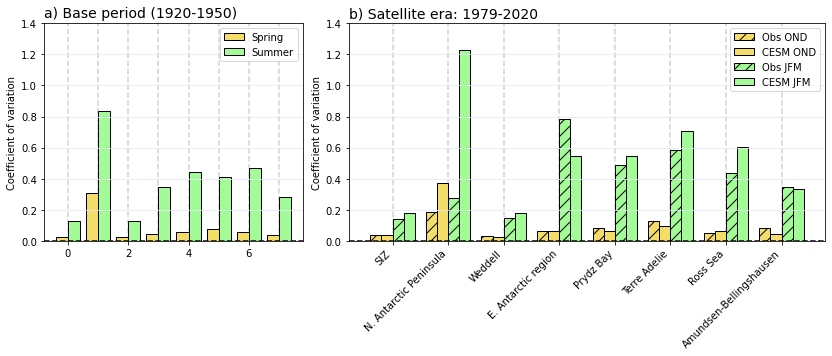

In [78]:
fig = plt.figure(figsize=(14,4))

gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=(1.2, 1, 1))


ax_base = plt.subplot(gs[0, 0])
ax_sat = plt.subplot(gs[0, 1:3])

labels = ['SIZ','N. Antarctic Peninsula','Weddell','E. Antarctic region','Prydz Bay','Terre Adelie','Ross Sea','Amundsen-Bellingshausen']

inds = np.arange(0,len(labels))

var = 'IFRAC_OND_SIA_km2'
valsOND = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

var = 'IFRAC_JFM_SIA_km2'
valsJFM = [basestd_SIZ[var].values/basemean_SIZ[var].values,
       basestd_AP[var].values/basemean_AP[var].values,
       basestd_Wedd[var].values/basemean_Wedd[var].values,
       basestd_EAnt[var].values/basemean_EAnt[var].values,
       basestd_Prydz[var].values/basemean_Prydz[var].values,
       basestd_Adelie[var].values/basemean_Adelie[var].values,
       basestd_Ross[var].values/basemean_Ross[var].values,
       basestd_AmBel[var].values/basemean_AmBel[var].values]

ax_base.bar(inds-0.2, valsOND, color=(245/255,221/255,106/255),width=0.4, label='Spring', edgecolor='black')
ax_base.bar(inds+0.2, valsJFM, color=(162/255,251/255,151/255),width=0.4, label='Summer', edgecolor='black')
ax_base.set_title('a) Base period (1920-1950)',fontsize=14,loc='left')
ax_base.set_ylabel('Coefficient of variation')


plt.xticks(inds, labels,rotation=45, ha='right');



ax_base.axhline(0,linestyle='--',color='black')
ax_base.set_ylim(0,1.4)
for i in inds:
    ax_base.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax_base.legend()
ax_base.yaxis.grid(True, which='major',color='lavender')


############# SATELLITE ERA
spr_color = (245/255,221/255,106/255)

sum_color = (162/255,251/255,151/255)

var = 'sic_ond_SIA_km2'
valsONDcdr = [ds_regs_ONDstd_cdr['SIZ'].values/ds_regs_ONDmean_cdr['SIZ'].values,
       ds_regs_ONDstd_cdr['AP'].values/ds_regs_ONDmean_cdr['AP'].values,
       ds_regs_ONDstd_cdr['Wedd'].values/ds_regs_ONDmean_cdr['Wedd'].values,
       ds_regs_ONDstd_cdr['EAnt'].values/ds_regs_ONDmean_cdr['EAnt'].values,
       ds_regs_ONDstd_cdr['Prydz'].values/ds_regs_ONDmean_cdr['Prydz'].values,
       ds_regs_ONDstd_cdr['Adelie'].values/ds_regs_ONDmean_cdr['Adelie'].values,
       ds_regs_ONDstd_cdr['Ross'].values/ds_regs_ONDmean_cdr['Ross'].values,
       ds_regs_ONDstd_cdr['AmBel'].values/ds_regs_ONDmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsONDcesm = [ds_regs_ONDstd_cesm['SIZ'].values/ds_regs_ONDmean_cesm['SIZ'].values,
       ds_regs_ONDstd_cesm['AP'].values/ds_regs_ONDmean_cesm['AP'].values,
       ds_regs_ONDstd_cesm['Wedd'].values/ds_regs_ONDmean_cesm['Wedd'].values,
       ds_regs_ONDstd_cesm['EAnt'].values/ds_regs_ONDmean_cesm['EAnt'].values,
       ds_regs_ONDstd_cesm['Prydz'].values/ds_regs_ONDmean_cesm['Prydz'].values,
       ds_regs_ONDstd_cesm['Adelie'].values/ds_regs_ONDmean_cesm['Adelie'].values,
       ds_regs_ONDstd_cesm['Ross'].values/ds_regs_ONDmean_cesm['Ross'].values,
       ds_regs_ONDstd_cesm['AmBel'].values/ds_regs_ONDmean_cesm['AmBel'].values]

var = 'sic_jfm_SIA_km2'
valsJFMcdr = [ds_regs_JFMstd_cdr['SIZ'].values/ds_regs_JFMmean_cdr['SIZ'].values,
       ds_regs_JFMstd_cdr['AP'].values/ds_regs_JFMmean_cdr['AP'].values,
       ds_regs_JFMstd_cdr['Wedd'].values/ds_regs_JFMmean_cdr['Wedd'].values,
       ds_regs_JFMstd_cdr['EAnt'].values/ds_regs_JFMmean_cdr['EAnt'].values,
       ds_regs_JFMstd_cdr['Prydz'].values/ds_regs_JFMmean_cdr['Prydz'].values,
       ds_regs_JFMstd_cdr['Adelie'].values/ds_regs_JFMmean_cdr['Adelie'].values,
       ds_regs_JFMstd_cdr['Ross'].values/ds_regs_JFMmean_cdr['Ross'].values,
       ds_regs_JFMstd_cdr['AmBel'].values/ds_regs_JFMmean_cdr['AmBel'].values]

var = 'IFRAC_OND_SIA_km2'
valsJFMcesm = [ds_regs_JFMstd_cesm['SIZ'].values/ds_regs_JFMmean_cesm['SIZ'].values,
       ds_regs_JFMstd_cesm['AP'].values/ds_regs_JFMmean_cesm['AP'].values,
       ds_regs_JFMstd_cesm['Wedd'].values/ds_regs_JFMmean_cesm['Wedd'].values,
       ds_regs_JFMstd_cesm['EAnt'].values/ds_regs_JFMmean_cesm['EAnt'].values,
       ds_regs_JFMstd_cesm['Prydz'].values/ds_regs_JFMmean_cesm['Prydz'].values,
       ds_regs_JFMstd_cesm['Adelie'].values/ds_regs_JFMmean_cesm['Adelie'].values,
       ds_regs_JFMstd_cesm['Ross'].values/ds_regs_JFMmean_cesm['Ross'].values,
       ds_regs_JFMstd_cesm['AmBel'].values/ds_regs_JFMmean_cesm['AmBel'].values]

ax_sat.yaxis.grid(True, which='major',color='lavender')
ax_sat.bar(inds-0.3, valsONDcdr, color=spr_color,width=0.2, edgecolor='black', hatch='//', label='Obs OND')
ax_sat.bar(inds-0.1, valsONDcesm, color=spr_color,width=0.2, edgecolor='black', label='CESM OND')
ax_sat.bar(inds+0.1, valsJFMcdr, color=sum_color,width=0.2, edgecolor='black', hatch='//', label='Obs JFM')
ax_sat.bar(inds+0.3, valsJFMcesm, color=sum_color,width=0.2, edgecolor='black', label='CESM JFM')


ax_sat.set_title('b) Satellite era: 1979-2020',fontsize=14,loc='left')
ax_sat.set_ylabel('Coefficient of variation')
#plt.xticks(inds, labels,rotation=45, ha='right');
ax_sat.axhline(0,linestyle='--',color='black')
ax_sat.set_ylim(0,1.4)
for i in inds:
    ax_sat.axvline(inds[i],linestyle='--',color='lightgray',zorder=0)
ax_sat.legend()


#fig.savefig('/glade/work/kristenk/figs/FigS7_coeff_var_SIA_regs_obs-model.png', bbox_inches='tight', dpi=300, format='png');